This notebook described the PTRPC analysis - CD45KO 

# Load Libraries

In [31]:
suppressPackageStartupMessages({
    library(gdata)
    library(singlecellmethods)
    library(matrixStats)
    library(data.table)
    library(viridis)
    #library(seaborn)
    library(RColorBrewer)
    library(ComplexHeatmap)
    library(Matrix)
    library(harmony)
    library(uwot)
    library(irlba)
    library(Seurat)
    library(factoextra)
    library(presto) 
    source("DNA_filtering_Functions.R")
    source("misc_funcs.R")
    source("utils.R")
    library(tidyverse)
    library(ggpubr)
    library(ggridges)
    library(ggrepel)
})

# Load All libraries. Skip steps below

In [32]:
FlowMatrix <- read_csv("FlowMatrixFinal.csv")

Rows: 6144 Columns: 23
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (12): Well_ID, DNA_cell, RNA_cell, Experiment_Index, Plate, Edited_Index...
dbl (11): PB_CD81, BV605_CD45, BV750_CD45, SSC, FSC, FITC_CD45, PE_CD81, PEC...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [33]:
#Load Meta RNA
meta <- read_csv("meta.csv")

Rows: 6144 Columns: 13
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (10): plate, cell, PlateLabel, Condition, DNA_Barcode, ADT_Barcode, sgRN...
dbl  (3): nUMI, nGenes, pctMito

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [34]:
#Import RNA - processed separately 
exprs <- readMM(file = "exprs.mtx")
colnames(exprs) <- read_csv("exprs_colnames.csv") %>% with(x)
rownames(exprs) <- read_csv("exprs_rownames.csv") %>% with(x)

New names:
• `` -> `...1`
Rows: 6144 Columns: 2
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (1): x
dbl (1): ...1

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
New names:
• `` -> `...1`
Rows: 36591 Columns: 2
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (1): x
dbl (1): ...1

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [35]:
#Import ADT
meta_adt_filt <- read_csv("meta_ADT_filt.csv")
counts_adt_filt <- readMM(file = "counts_ADT_filt.mtx")
colnames(counts_adt_filt) <- read_csv("colnames_counts_ADT_filt.csv") %>% with(x)
rownames(counts_adt_filt) <- read_csv("rownames_counts_ADT_filt.csv") %>% with(x)


Rows: 6038 Columns: 12
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (10): plate, cell_adt, PlateLabel, Condition, RNA_Barcode, DNA_Barcode, ...
dbl  (2): nUMI, nGenes

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
New names:
• `` -> `...1`
Rows: 6144 Columns: 2
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (1): x
dbl (1): ...1

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
New names:
• `` -> `...1`
Rows: 154 Columns: 2
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────

In [36]:
#Add DNA
meta_DNA <- read_csv("CD45_RPL8_TYK2_Meta.csv")
alleles_DNA <- read_csv("alleles_DNA.csv")
#Add Meta 
alleles_DNA_meta<- inner_join(alleles_DNA, meta_DNA)

Rows: 16 Columns: 8
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (8): PlateLabel, Condition, RNA_Barcode, DNA_Barcode, ADT_Barcode, sgRNA...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 8389 Columns: 8
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (3): DNA_Barcode, Well_ID, Aligned_Sequence
dbl (5): n_deleted, n_inserted, n_mutated, #Reads, %Reads

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining with `by = join_by(DNA_Barcode)`


# Subset DNA - CD45

In [37]:
#subset for analysis
CD45_alleles_DNA <- filter(alleles_DNA_meta, Condition == "CD45")

In [38]:
CD45_alleles_DNA <- rename(CD45_alleles_DNA, "Barcode_DNA" = DNA_Barcode)

# Genomic DNA Amplicon Analysis

In [39]:
DNAfiles = "Analysis/Alleles"

In [11]:
#Alleles Function for Import - Updated- Fixed Naming to Automate and Changed to Capture the top 10 alleles per cell. 
AllelesFunction <- 
function (filepath, number_of_alleles = 10, folder_name="Alleles") #Filepath is the folder with all the allele tables. 
{
    files <- list.files(path = filepath, pattern = ".txt$", full.names = T, 
        recursive = T) 
    
    matrix <- suppressMessages({
        suppressWarnings({
            lapply(files, read_tsv, n_max = number_of_alleles, col_select = c(1, 
                5, 6, 7, 8, 9))
        })
    })
    names(matrix) <- lapply(files, FUN = 
      function(x) { 
          paste0(substr(x, str_locate(x, paste0(folder_name, "/"))[2]+1, str_locate(x, "/CRISPRessoBatch_on_batch")[1]-1), #modified for Full
                            "_", 
                             substr(x, str_locate(x, "CRISPResso_on_([A-Z])(\\d)")[2]-1, str_locate(x, "/Alleles_frequency_table.txt")[1]-1))})
    
    matrix <- bind_rows(matrix, .id = "Plate_Well")
    return(matrix)
}

In [47]:
#Upload all Alleles
alleles_DNA <- AllelesFunction(DNAfiles, folder_name="Alleles")

In [58]:
#add meta data
alleles_DNA <- alleles_DNA %>% separate(Plate_Well, into = c("DNA_Barcode", "Well_ID")) %>% 
inner_join(meta_DNA)

Joining with `by = join_by(DNA_Barcode)`


In [59]:
write_csv(alleles_DNA, "alleles_DNA_updated.csv")

In [40]:
alleles_DNA <- read_csv("alleles_DNA_updated.csv")

Rows: 34706 Columns: 15
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (10): DNA_Barcode, Well_ID, Aligned_Sequence, PlateLabel, Condition, RNA...
dbl  (5): n_deleted, n_inserted, n_mutated, #Reads, %Reads

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [41]:
CD45_alleles <- filter(alleles_DNA, Condition == "CD45")

In [42]:
CD45_alleles <- rename(CD45_alleles, Barcode_DNA = DNA_Barcode)

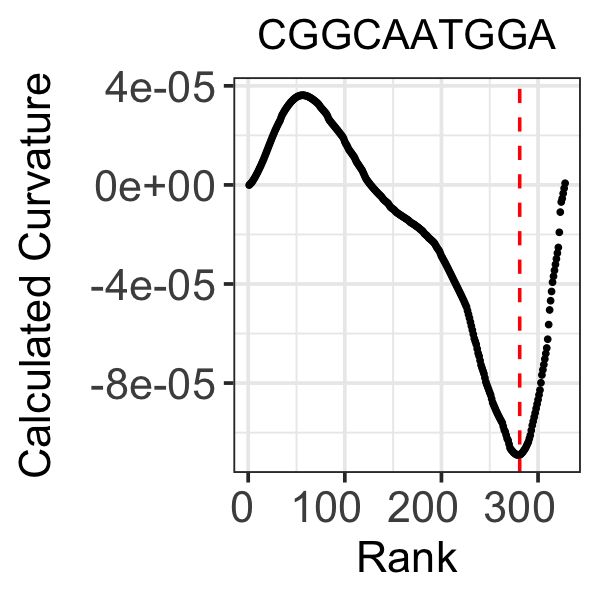

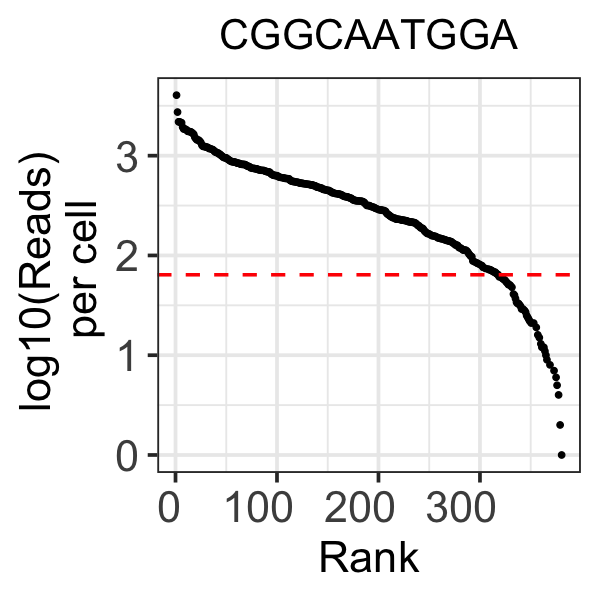

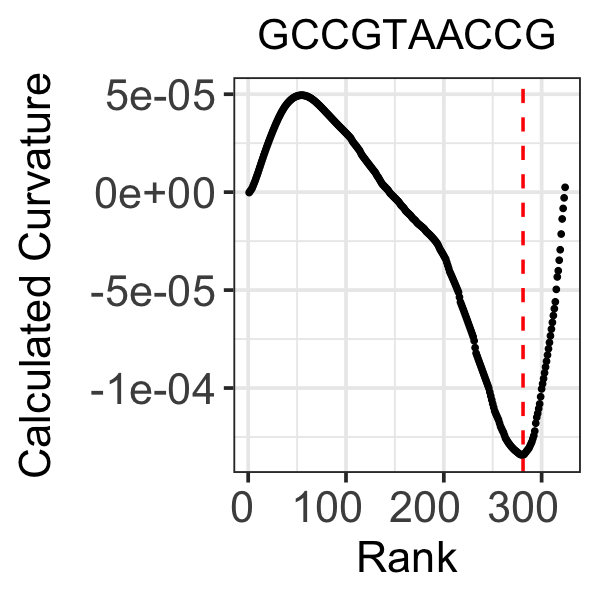

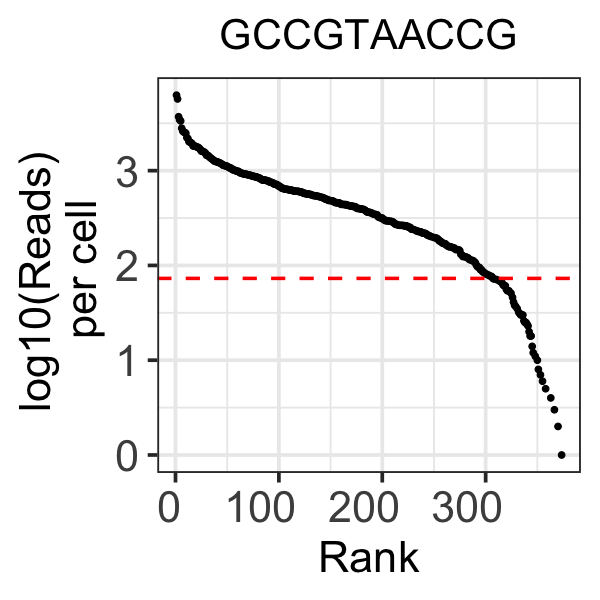

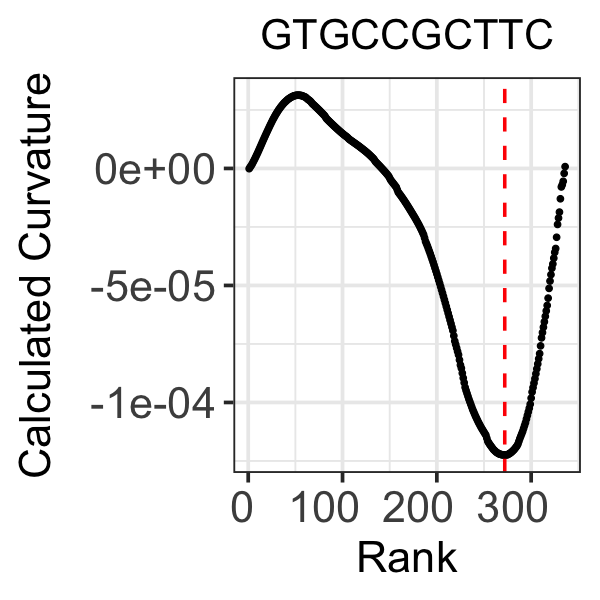

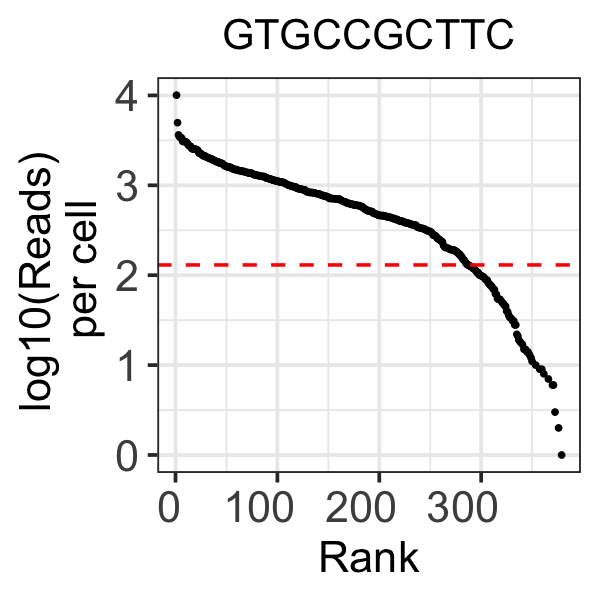

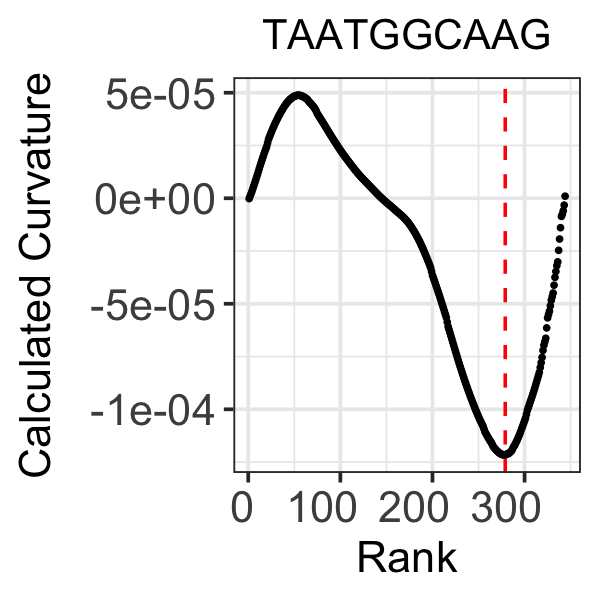

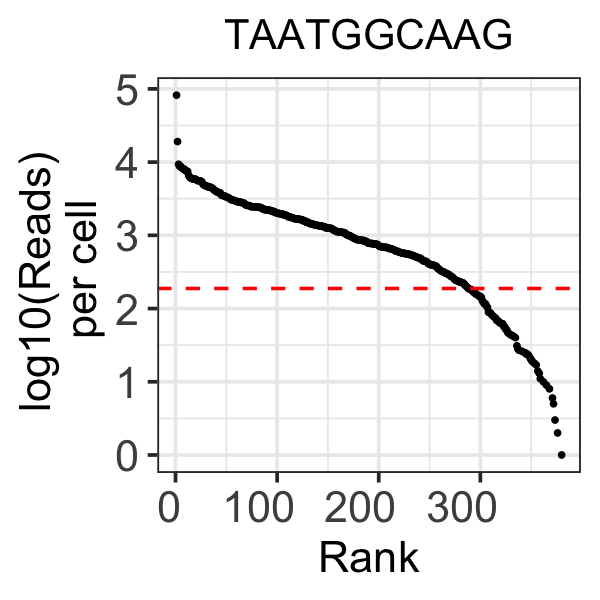

In [43]:
fig.size(5,5)
CD45_alleles <- Filtering_Cells_Read(CD45_alleles)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


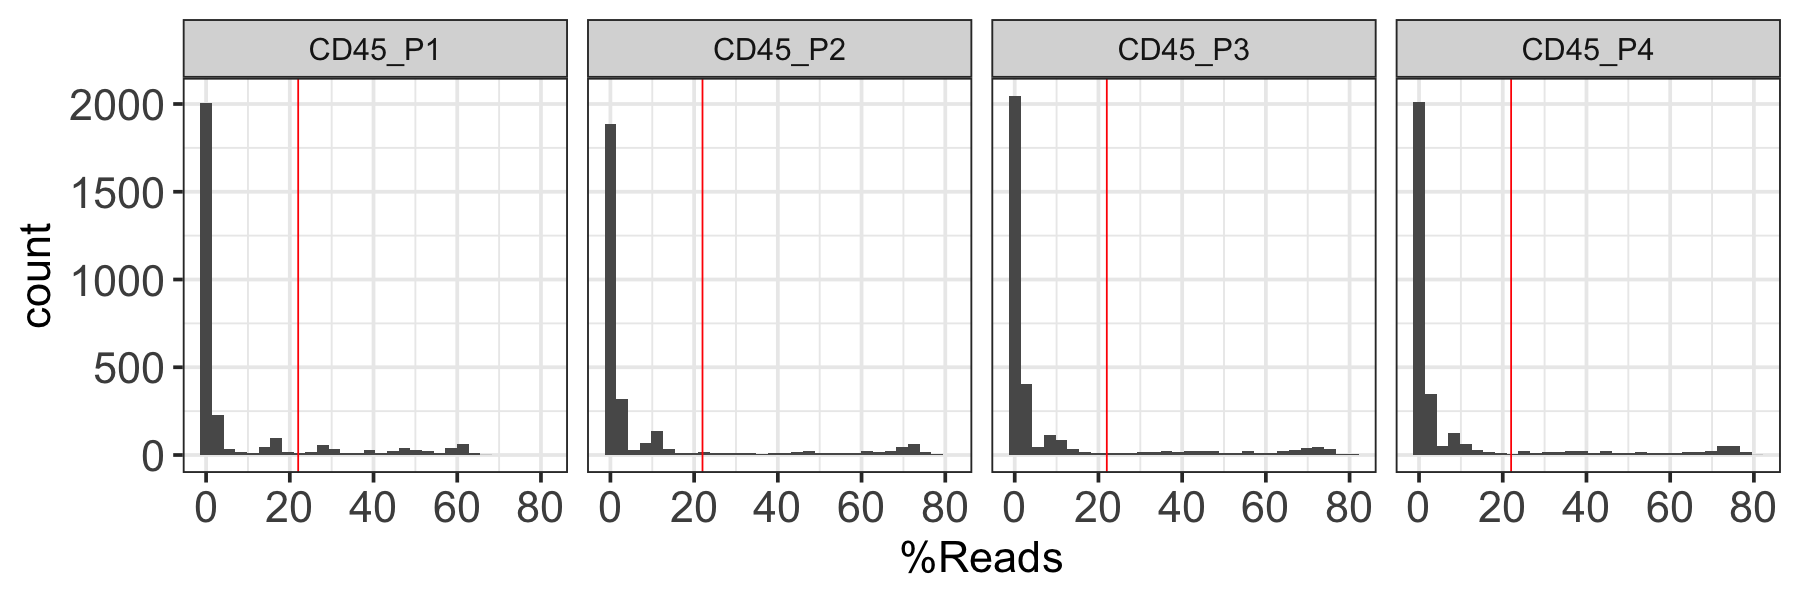

In [44]:
fig.size(5,15)
#Define a cutoff
CD45_alleles %>% 
    ggplot(aes(`%Reads`)) + geom_histogram() + 
    theme_gy() + geom_vline(xintercept = 22, color = "red") + facet_grid(~PlateLabel)

In [45]:
source("/Users/bagtq9/Desktop/Box Sync/2017 - Raychaudhuri Lab/Lab Documents/scRNA-DNA GSK/Experiments/UpdatedExperiments/DNA_filtering_Functions.R")

In [46]:
CD45_filt <- CD45_alleles %>% Filtering_Alleles(cutoff=22)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


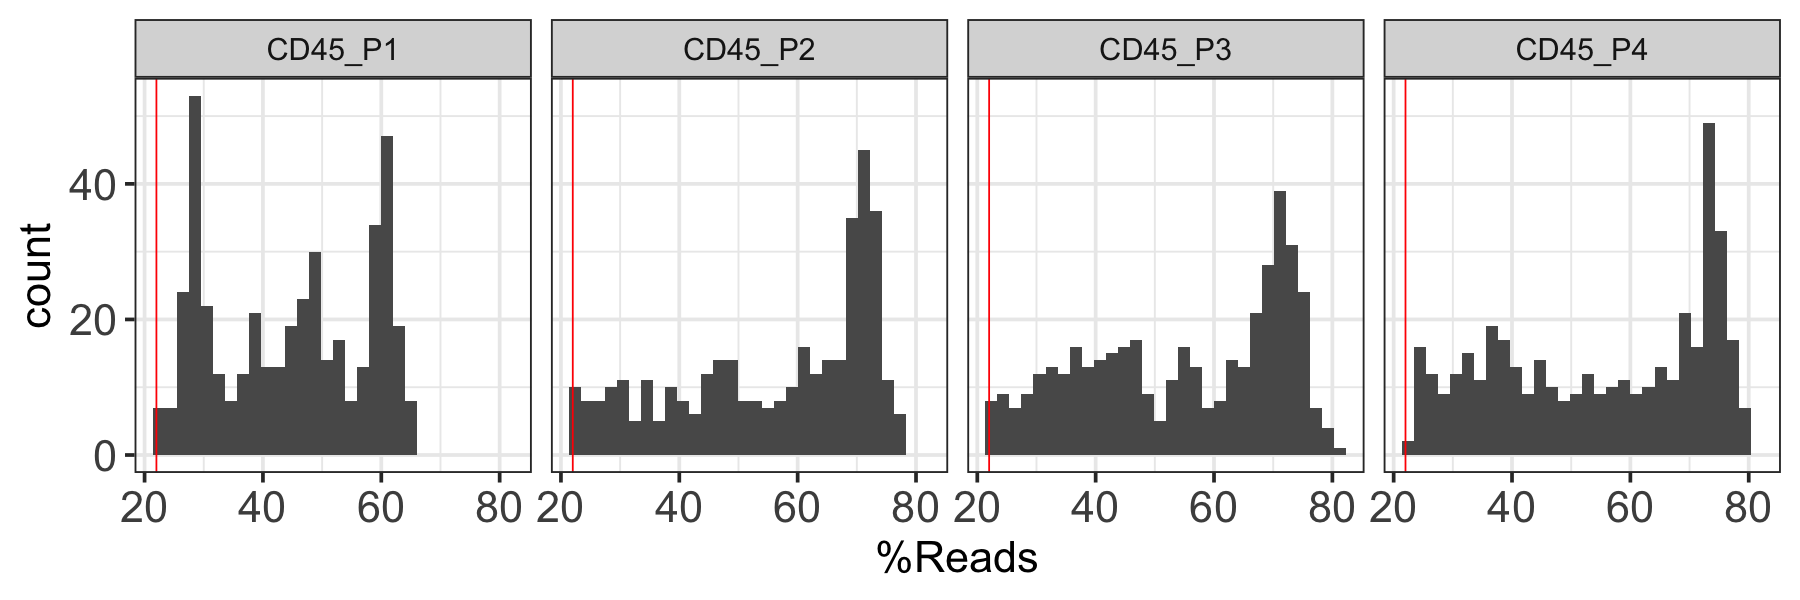

In [47]:
fig.size(5,15)
#Define a cutoff
CD45_filt %>% 
    ggplot(aes(`%Reads`)) + geom_histogram() + 
    theme_gy() + geom_vline(xintercept = 22, color = "red") + facet_grid(~PlateLabel)

In [48]:
#Match lenghts of Ref and Allele
CD45_filt <- mutate(CD45_filt, 
                               Aligned_Sequence = str_trunc(Aligned_Sequence, 180, "right", ""))
#Fix length from P7
CD45_filt<- CD45_filt %>% 
    mutate("Aligned_Sequence" = str_trunc(Aligned_Sequence, 150, "left", ellipsis = "")) %>% 
    mutate("Reference"= str_trunc(Reference, 150, "left", ellipsis = ""))%>% 
    mutate("Aligned_Sequence" = str_trunc(Aligned_Sequence, 40, "right", ellipsis = "")) %>% 
    mutate("Reference"= str_trunc(Reference, 40, "right", ellipsis = ""))

In [49]:
## Remove alleles found in less than 5 cells. 
CD45_filt <- CD45_filt  %>% add_count(name = "AlleleCount", Aligned_Sequence) %>% filter(AlleleCount >5)

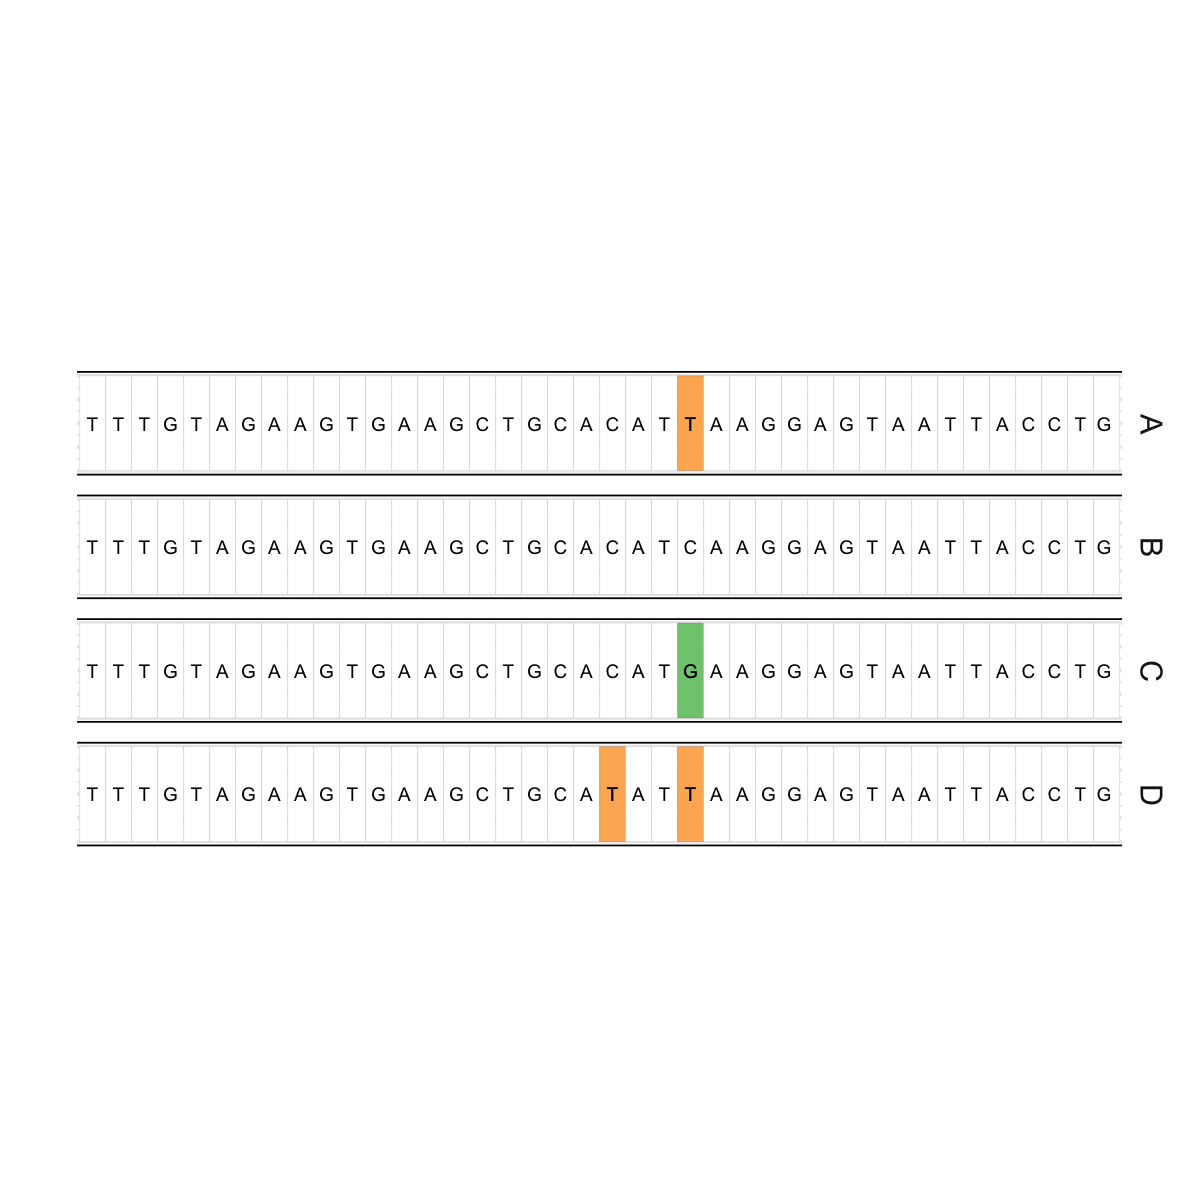

In [50]:
CD45_filt %>% Plotting_Alleles

In [51]:
CD45_gen <- Genotyping_Cells(CD45_filt)

# Quality Control

## RNA filtering on nGenes and nUMI (500, 1000)

In [ ]:
# QC figures

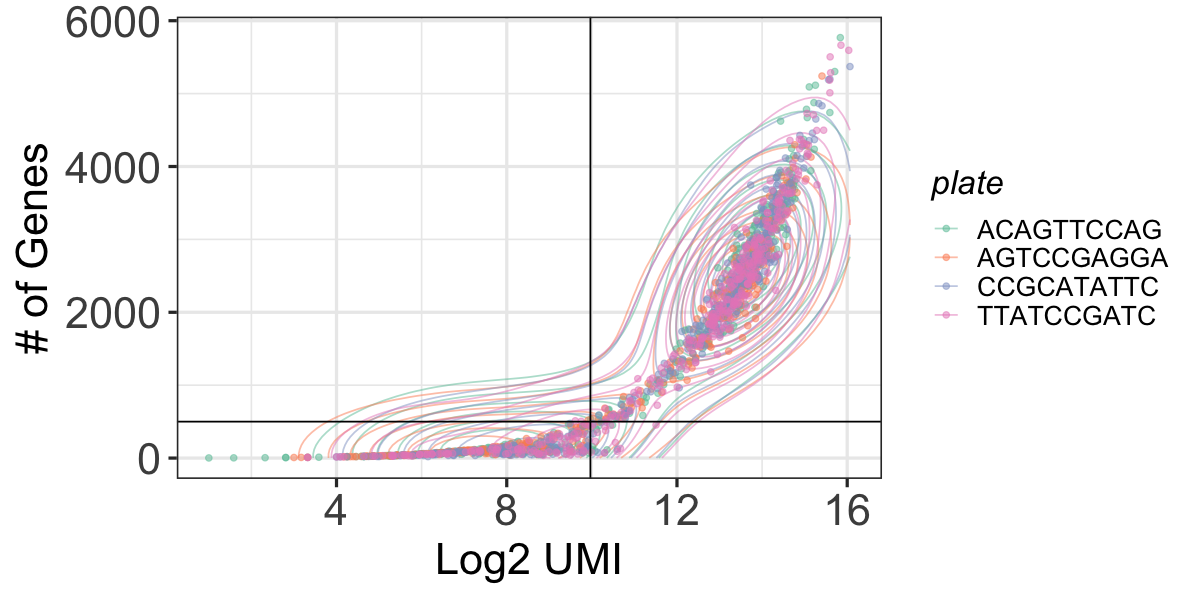

In [52]:
fig.size(5, 10)
ggplot(filter(meta, Condition == "CD45")) +
    geom_density_2d(aes(x=log2(nUMI), y=nGenes, color = plate), alpha = 0.5)+ 
    geom_point(aes(x=log2(nUMI), y=nGenes, color = plate), alpha = 0.5) +
    theme_gy(20) + ylab("# of Genes") + 
    xlab("Log2 UMI") + scale_color_brewer(palette = "Set2") + 
   geom_vline(xintercept = log2(1000))+ 
geom_hline(yintercept = 500)
    

In [53]:
nCells = rowSums(exprs > 0)
gene_qc = data.frame(nCells = nCells %>% sort %>% rev, rank = seq(1, length(nCells)))

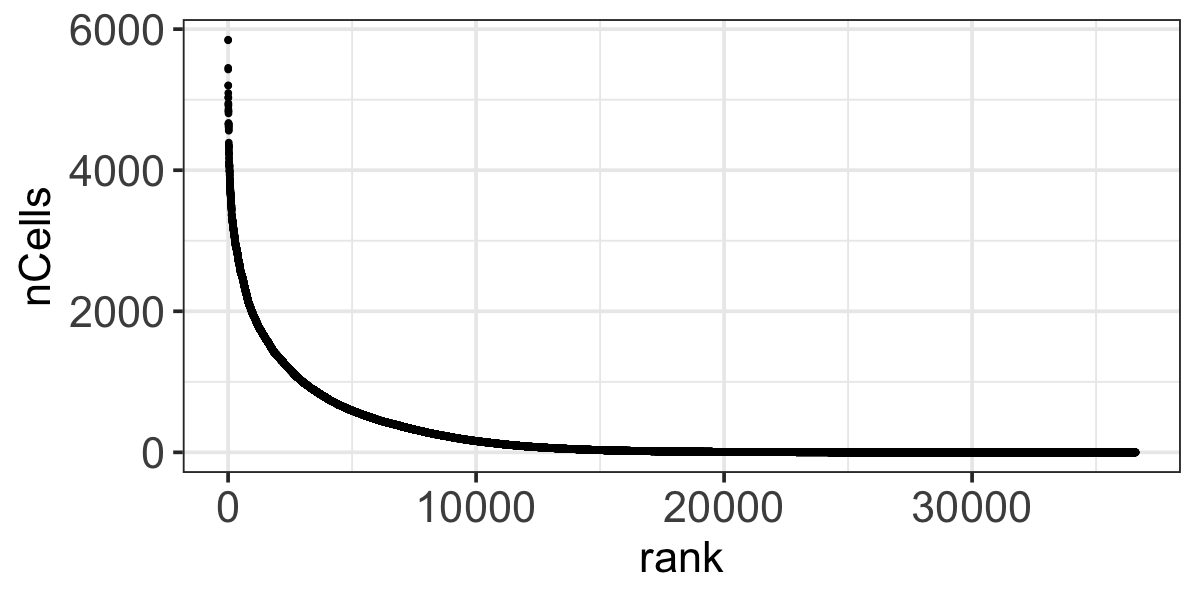

In [54]:
ggplot(gene_qc)+
    geom_point(aes(x = rank, y = nCells))+
    theme_gy()

In [55]:
nUMI_thresh =  1000 #5000 #40
nGene_thresh = 500
pctMito_thresh = 0.1
ncell_thresh = 10

filt_exprs = exprs[rownames(gene_qc %>% filter(nCells > ncell_thresh)), 
                   (meta %>% filter(nUMI > nUMI_thresh, 
                                               nGenes > nGene_thresh, 
                                               pctMito < pctMito_thresh) %>% with(cell))]
filt_meta = filter(meta, cell %in% colnames(filt_exprs))

## ADT QC

In [57]:
counts_ADT_filt <- counts_adt_filt

In [58]:
meta_ADT_filt <- meta_adt_filt

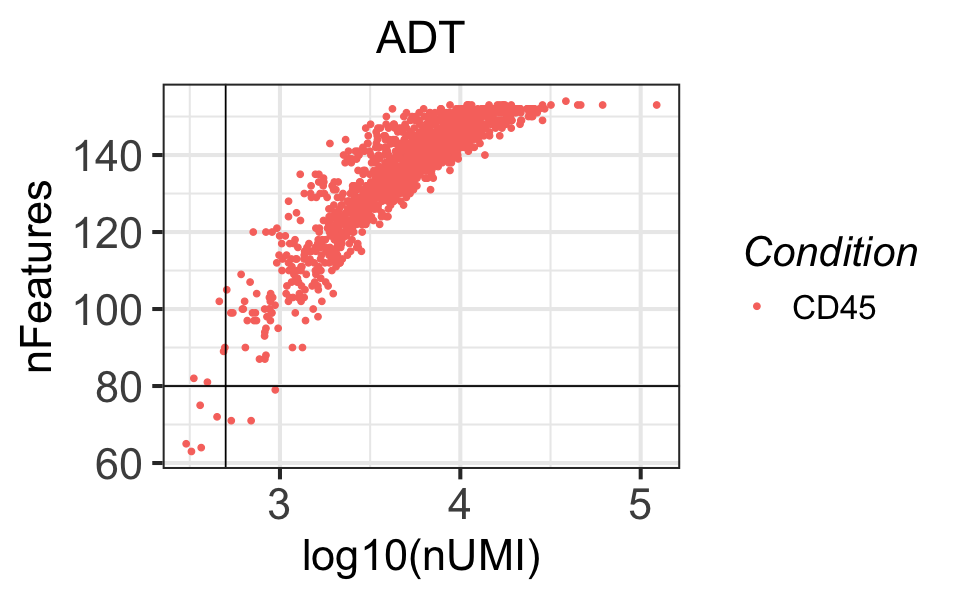

In [59]:
fig.size(5, 8)
ggplot(meta_ADT_filt %>% filter(Condition == "CD45"))+
    geom_point(aes(x=log10(nUMI), y=nGenes, col = Condition))+
    theme_gy(25)+
    # geom_vline(xintercept = log10(1e3))+
    ggtitle('ADT')+
    ylab('nFeatures')+
    geom_vline(xintercept = log10(500))+
    geom_hline(yintercept = 80)

In [60]:
meta_ADT_filt <- meta_ADT_filt %>% filter(nUMI >= 500 & nGenes >= 80)

In [61]:
counts_ADT_filt<- counts_ADT_filt[,(meta_ADT_filt$cell)]

# Pre-process expression data

In [62]:
#Add rownames
rownames(meta_ADT_filt) <- meta_ADT_filt$cell
rownames(filt_meta) <- filt_meta$cell

Warning message:
“Setting row names on a tibble is deprecated.”
Warning message:
“Setting row names on a tibble is deprecated.”


In [63]:
#select only CD45 data for RNA
filt_meta_CD45 <- filter(filt_meta, Condition == "CD45")
filt_exprs_CD45 <- filt_exprs[,filt_meta_CD45$cell]

In [64]:
#select only CD45 data for ADT
meta_ADT_filt_CD45 <- filter(meta_ADT_filt, Condition == "CD45")
counts_ADT_filt_CD45 <- counts_ADT_filt[,meta_ADT_filt_CD45$cell]

In [65]:
### Pre-process based on metadata conditions
scale_exprs_CD45 = process_rna(filt_exprs_CD45, 
                               filt_meta_CD45)

'as(<dgTMatrix>, "dgCMatrix")' is deprecated.
Use 'as(., "CsparseMatrix")' instead.
See help("Deprecated") and help("Matrix-deprecated").



In [66]:
scale_exprs_CD45 %>% dim

[1] 3000  901

# Merging of Flow & DNA & RNAmeta & ADTmeta data

In [67]:
CD45Plots <- CD45_filt %>% select(Barcode_DNA, Well_ID, plate_well) %>% unique %>% inner_join(CD45_gen) %>% 
inner_join(
    FlowMatrix %>% mutate(FlowMatrix,plate_well = paste0(DNA_Barcode, Well_ID))
    ) %>%
inner_join(select(
    meta_ADT_filt_CD45, 
    cell, nUMI, nGenes)) %>% 
inner_join(select(
    filt_meta_CD45, 
    cell, nUMI, nGenes), by = "cell") %>%
add_count(AllelicGenotype, name = "genotype_count") %>% filter(Plate != "P1")
# Plate 1 had bad DNA data, clearly problematic. #Needs to be removed from all assays in this experiment. Not included in final meta data. 
# Control cells act as ground truth. Along with genotype distribution. 

Joining with `by = join_by(plate_well)`
Joining with `by = join_by(Well_ID, plate_well)`
Joining with `by = join_by(cell)`


In [522]:
#export this table
write_csv(CD45Plots, "CD45Plots_Updated.csv")

In [253]:
CD45PlotsOLD <- read_csv("CD45Plots.csv")

Rows: 628 Columns: 32
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (15): DNA_Barcode, Well_ID, Alleles, Reference, PlateLabel, Condition, R...
dbl (17): genotype, PB_CD81, BV605_CD45, BV750_CD45, SSC, FSC, FITC_CD45, PE...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# UMAPs

In [68]:
set.seed(120)

In [ ]:
### Run PCA/Harmony/UMAP based on metadata conditions

## RNA

Warning message:
“Warning: The parameters do_pca and npcs are deprecated. They will be ignored for this function call and please remove parameters do_pca and npcs and pass to harmony cell_embeddings directly.
This warning is displayed once per session.”
Warning message:
“Warning: The parameter max.iter.harmony is replaced with parameter max_iter. It will be ignored for this function call and please use parameter max_iter in future function calls.
This warning is displayed once per session.”
Warning message:
“Warning: The parameter max.iter.cluster is deprecated. It will be ignored for this function call and please remove parameter max.iter.cluster in future function calls. Advanced users can set value of parameter max.iter.cluster by using parameter .options and function harmony_options().
This warning is displayed once per session.”
Warning message:
“Warning: The parameter epsilon.cluster is deprecated. It will be ignored for this function call and please remove parameter epsilon.clus

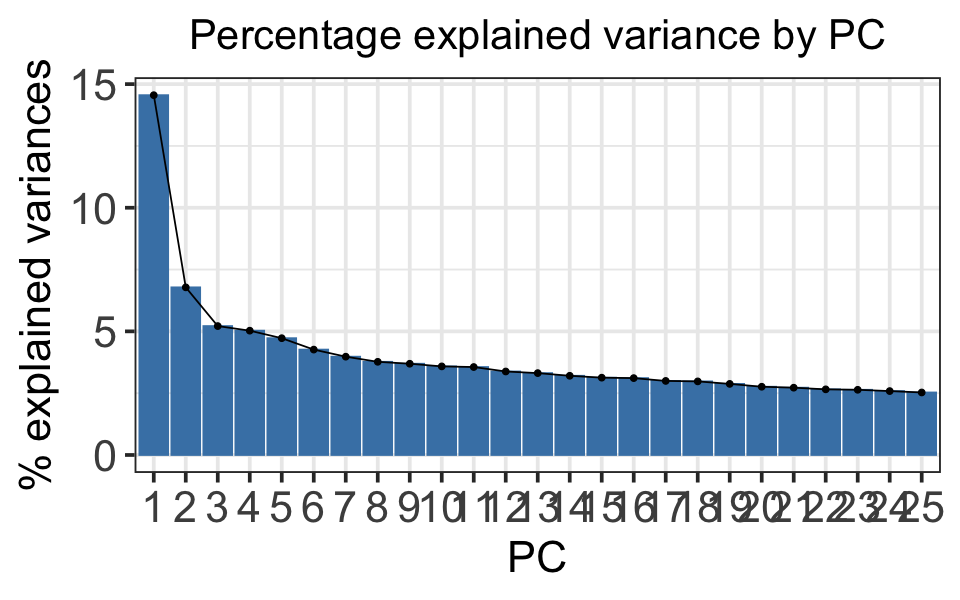

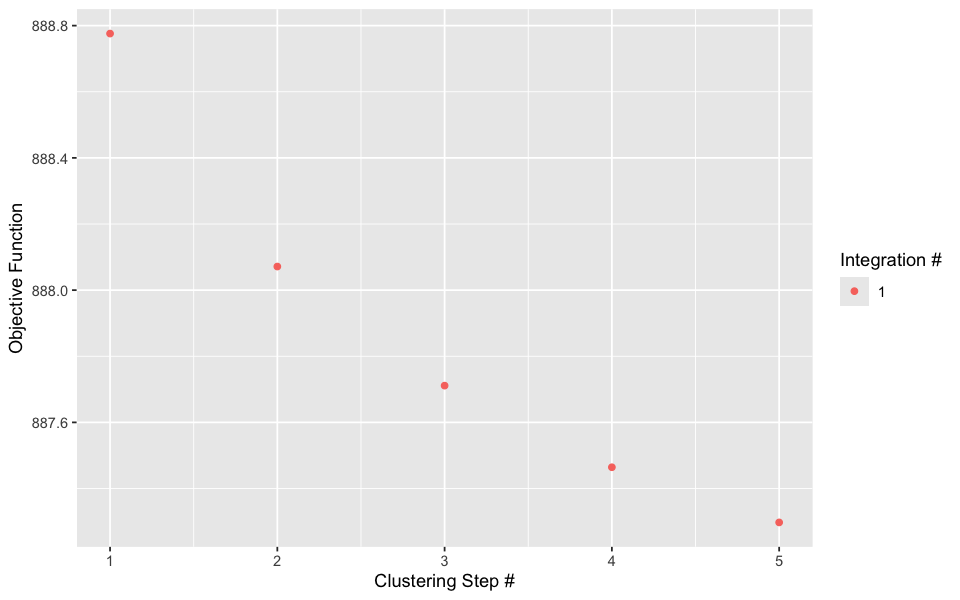

In [69]:
# Figure out overlapping cells with ADT, RNA, and DNA. Use that subset to cluster. 
filt_meta_CD45 <- filter(filt_meta, cell %in% CD45Plots$cell)
meta_umap_CD45 = pca_umap(scale_exprs_CD45[, filt_meta_CD45$cell], filt_meta_CD45, 
                          harmony_var = c('PlateLabel'))

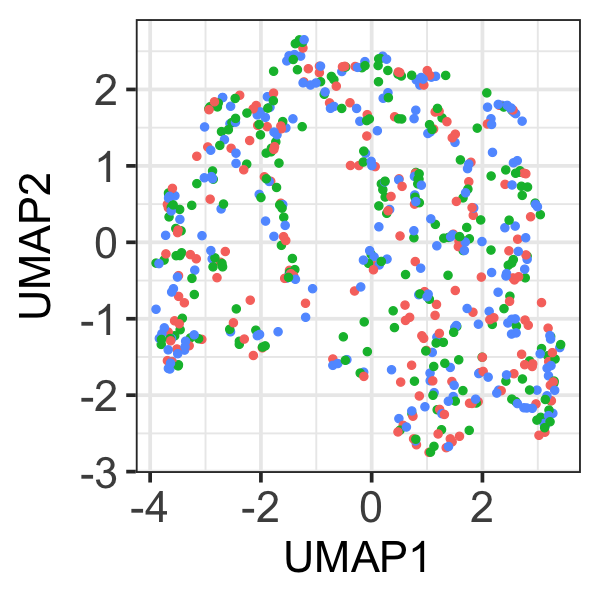

In [70]:
fig.size(5, 5)
ggplot(meta_umap_CD45 %>% sample_n(nrow(meta_umap_CD45)))+
    geom_point(aes(x = UMAP1, y = UMAP2, col = PlateLabel), size = 2)+
    theme_gy()+
theme(legend.position = "none")

In [71]:
scale_exprs <- normalizeData(filt_exprs, method = "log")

Joining with `by = join_by(cell)`


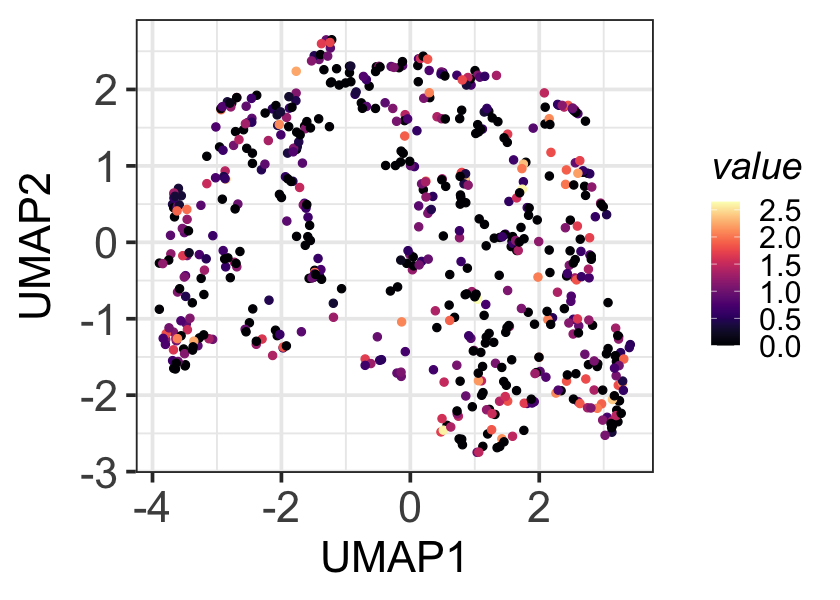

In [72]:
#CD45 gene expression differences?
fig.size(5,7)
scale_exprs["PTPRC",meta_umap_CD45$cell] %>% as_tibble(rownames = "cell")  %>% 
inner_join(meta_umap_CD45) %>% 

    ggplot()+
    geom_point(aes(x = UMAP1, y = UMAP2, col = value), size = 2)+
    theme_gy()+
     scale_color_viridis(option = "magma")+ 
theme(legend.position = "right")


## ADT

In [73]:
meta_adt_filt_CD45 <- filter(meta_ADT_filt, cell %in% CD45Plots$cell)

In [74]:
## filter adts to remove Igs ... causing problems. 
counts_ADT_filt <- counts_ADT_filt[!grepl(rownames(counts_ADT_filt), pattern = "Ig"),]

In [75]:
counts_ADT_filt <- counts_ADT_filt[,meta_adt_filt_CD45$cell]

Warning message:
“package ‘EnvStats’ was built under R version 4.3.3”

Attaching package: ‘EnvStats’


The following object is masked from ‘package:matrixStats’:

    iqr


The following objects are masked from ‘package:stats’:

    predict, predict.lm




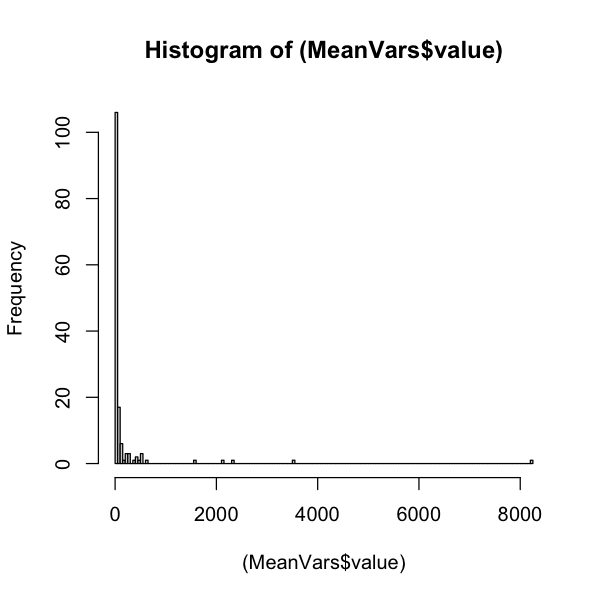

In [77]:
fig.size(5,5)
## Need to work out some kind of ADT filtering strategy as the ADTs fail to converge. Some assumptions are broken. 
## Variance is too high to estimate changes for mean expression. 
#Calcuate Variance over Mean (too high indicates that the expression is low and variance is too high)
library(EnvStats) #Load outlier library
MeanVars <- (rowVars(as.matrix(counts_ADT_filt))/ rowMeans(counts_ADT_filt)  ) %>% as_tibble(rownames = "gene") %>% arrange(-value)
hist((MeanVars$value), breaks = length(MeanVars$value)) #estimate outliers based on distributions

In [80]:
#set K
outliers <- rosnerTest(MeanVars$value, k = 5) %>% with(all.stats) %>% with(Obs.Num) #identify outliers with rosnerTest
genes <- MeanVars$gene[-outliers] # remove outliers

In [81]:
counts_ADT_filt_CD45 <- counts_ADT_filt[genes,]

In [82]:
scale_adt_CD45 = process_adt(counts_ADT_filt_CD45, 
                        meta_ADT_filt_CD45)

Transposing data matrix

Initializing state using k-means centroids initialization

Harmony 1/10

Harmony converged after 1 iterations

Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by ‘spam’

Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by ‘spam’



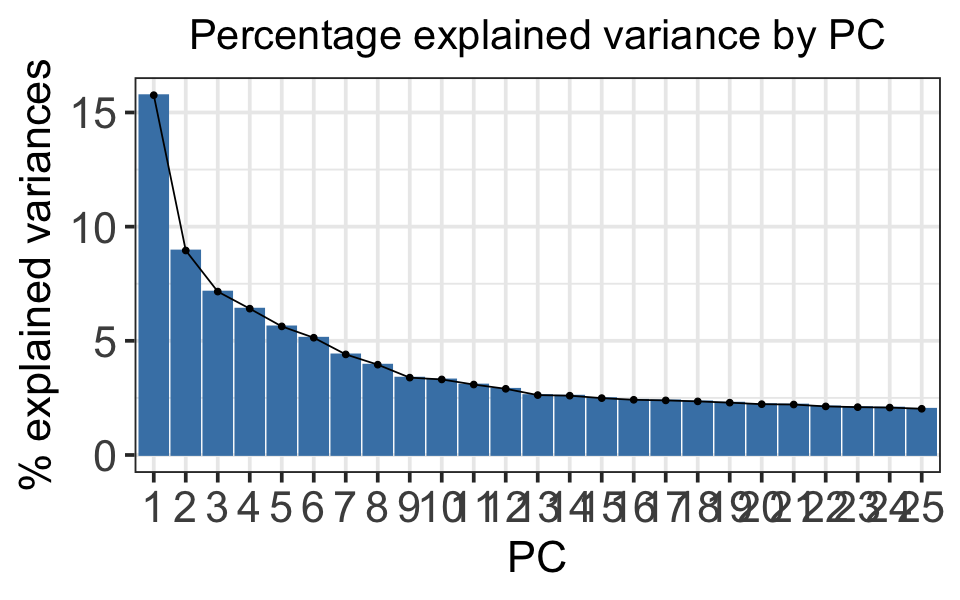

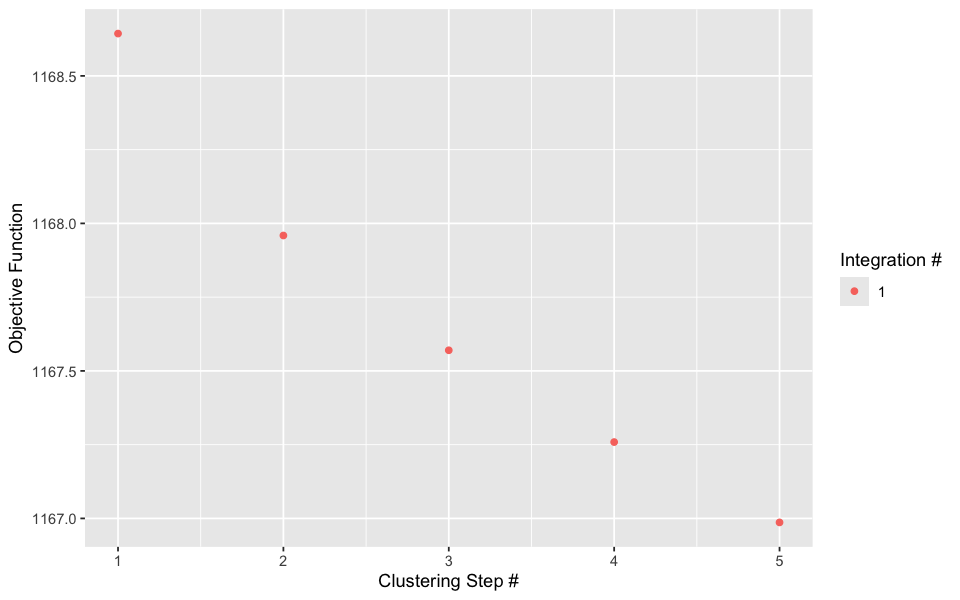

In [83]:
meta_umap_adt_CD45 <- pca_umap(scale_adt_CD45, meta_adt_filt_CD45, harmony_var = "PlateLabel")

In [85]:
scale_adt <- scale_adt_CD45

Joining with `by = join_by(cell)`


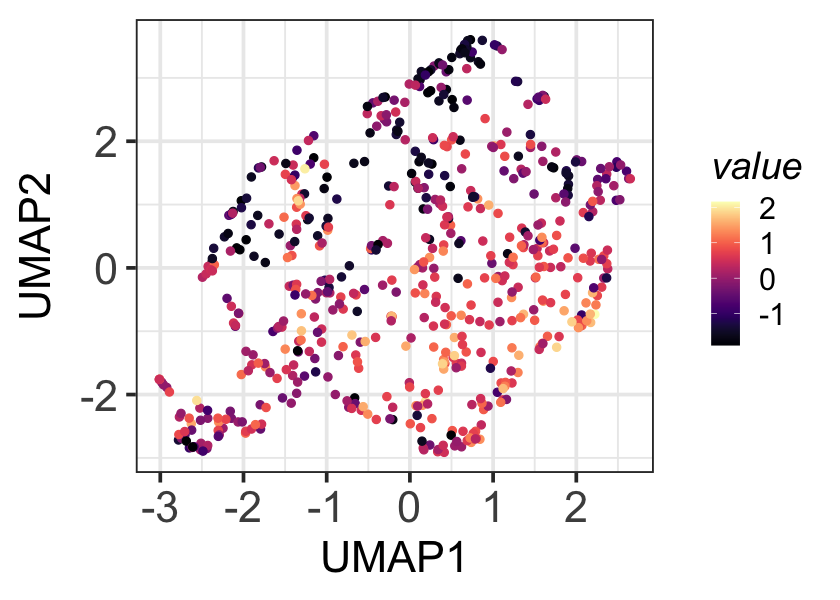

In [86]:
fig.size(5,7)
scale_adt["CD45",meta_umap_adt_CD45$cell] %>% as_tibble(rownames = "cell")  %>% 
inner_join(meta_umap_adt_CD45) %>% 

    ggplot()+
    geom_point(aes(x = UMAP1, y = UMAP2, col = value), size = 2)+
    theme_gy()+
     scale_color_viridis(option = "magma")+ 
theme(legend.position = "right")


# Clustering + DGE

## RNA

In [88]:
meta_umap_CD45.clust = do_cluster(meta_umap_CD45, resolution_list = seq(0.05, 0.5, 0.05))

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 618
Number of edges: 20830

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9500
Number of communities: 1
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 618
Number of edges: 20830

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9000
Number of communities: 1
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 618
Number of edges: 20830

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8500
Number of communities: 1
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 618
Number of edges: 20830

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8233
Number of communities: 2
Elapsed time: 0 seconds
Modularity Optimizer version

In [89]:
table(meta_umap_CD45.clust$`res.0.2`)


  0   1 
350 268 

In [90]:
meta_umap_CD45.clust$cluster = meta_umap_CD45.clust$`res.0.2`

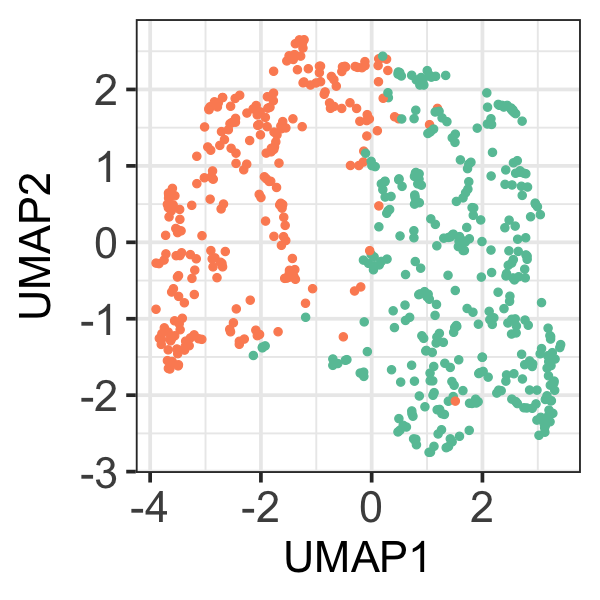

In [91]:
fig.size(5, 5)
ggplot(meta_umap_CD45.clust[sample(rownames(meta_umap_CD45.clust)), ])+
    geom_point(aes(x= UMAP1, y = UMAP2, col = cluster), size = 2)+
theme_gy() + 
theme(legend.position = "none") + 
scale_color_brewer(palette = "Set2")

In [94]:
df<-meta_umap_CD45.clust %>% arrange(cluster)
dge_CD45 = wilcoxauc(scale_exprs_CD45[,df$cell], df$cluster)
var_genes_CD45 = top_markers(dge_CD45, 5) %>% head(5) %>% select(-rank) %>% 
                        unlist %>% unique 
cmax = abs(scale_exprs_CD45[var_genes_CD45,df$cell ]) %>% unlist %>% max #%>% quantile(.995)

# Data frame with column annotations.
mat_col <- data.frame(cluster = df$cluster)
rownames(mat_col) <- rownames(df)


# Sort dendogram
mat_cluster_cols <- hclust(dist(t(scale_exprs_CD45[var_genes_CD45, df$cell])))
mat_cluster_cols <- sort_hclust(mat_cluster_cols)
mat_cluster_rows <- sort_hclust(hclust(dist(scale_exprs_CD45[var_genes_CD45,df$cell ])))

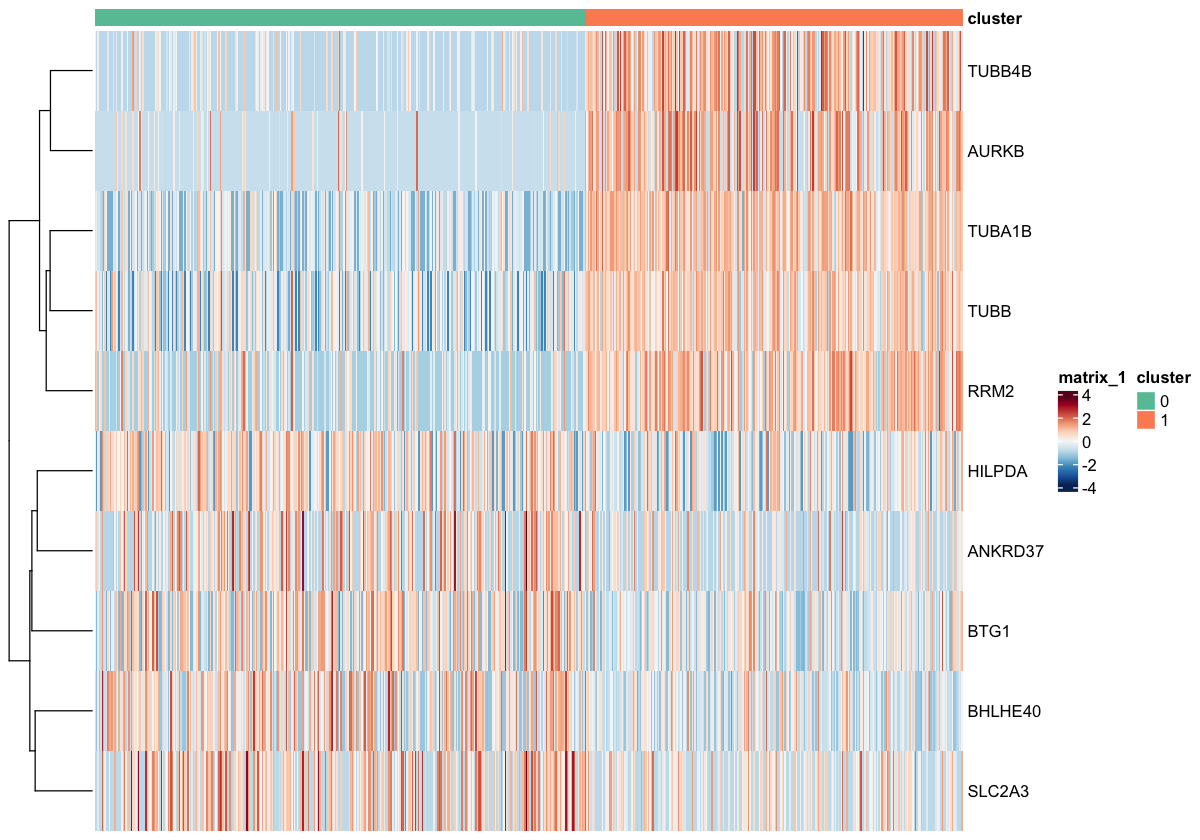

In [95]:
fig.size(7, 10)
pheatmap(scale_exprs_CD45[c(var_genes_CD45), df$cell],
         breaks = seq(-cmax, cmax, length.out = 100),
        color = colorRampPalette(brewer.pal(11, "RdBu"))(100) %>% rev,
        show_colnames = FALSE,
         annotation_col = mat_col, 
         fontsize = 10,
         cluster_cols = F,
         annotation_colors = list(cluster = c(
                                  `0` = "#66C2A5", 
                                  `1` = "#FC8D62" 
            #                      `2` = "#8DA0CB"
                                     )),
        cluster_rows = mat_cluster_rows,

        )

## ADT

In [96]:
meta_umap_adt_CD45.clust = do_cluster(meta_umap_adt_CD45, resolution_list = seq(0.1, 1, 0.1))

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 618
Number of edges: 22194

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9000
Number of communities: 1
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 618
Number of edges: 22194

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8000
Number of communities: 1
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 618
Number of edges: 22194

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7125
Number of communities: 2
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 618
Number of edges: 22194

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.6614
Number of communities: 3
Elapsed time: 0 seconds
Modularity Optimizer version

In [103]:
table(meta_umap_adt_CD45.clust$'res.0.4')


  0   1   2 
292 225 101 

In [104]:
meta_umap_adt_CD45.clust$cluster = meta_umap_adt_CD45.clust$`res.0.4`

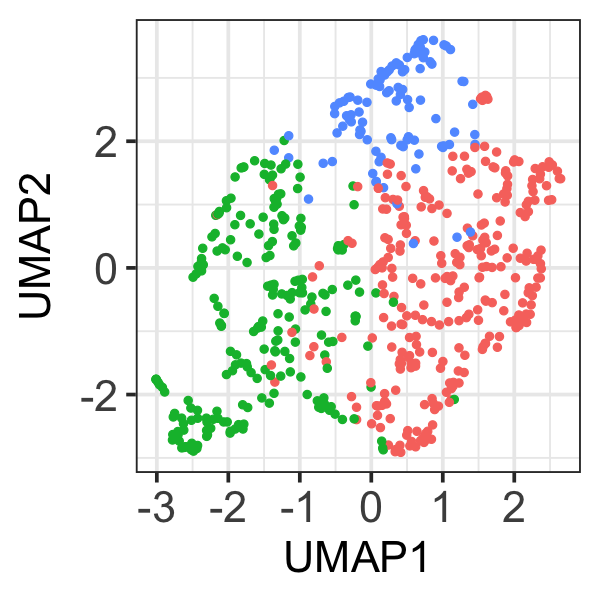

In [105]:
fig.size(5, 5)
ggplot(meta_umap_adt_CD45.clust[sample(rownames(meta_umap_adt_CD45.clust)), ])+
    geom_point(aes(x= UMAP1, y = UMAP2, col = cluster), size = 2)+
  theme_gy() + 
theme(legend.position = "none")

Rows: 384 Columns: 2
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (2): Well_ID, RNA_cell

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining with `by = join_by(Well_ID)`
Joining with `by = join_by(plate_well)`
Joining with `by = join_by(cell)`


plate_well    cell                     
1   CGGCAATGGAA1  AACATCTCTGTGAC_CCGCATATTC
2   CGGCAATGGAA10 AAGCTCCACTCAGA_CCGCATATTC
3   CGGCAATGGAA13 AATGCCGTTACACA_CCGCATATTC
4   CGGCAATGGAA14 AATGCGCATACAGT_CCGCATATTC
5   CGGCAATGGAA16 AATGTCATCGCGCT_CCGCATATTC
6   CGGCAATGGAA18 ACAAGAGACTCCAA_CCGCATATTC
7   CGGCAATGGAA21 ACACTCAGCTGTAA_CCGCATATTC
8   CGGCAATGGAA22 ACAGAGAACCGCTC_CCGCATATTC
9   CGGCAATGGAA23 ACAGCTATGATCGT_CCGCATATTC
10  CGGCAATGGAA5  AACGAGCTGGCAAG_CCGCATATTC
11  CGGCAATGGAA6  AACTACGTCTGTGC_CCGCATATTC
12  CGGCAATGGAA8  AAGAAGACACCGAT_CCGCATATTC
13  CGGCAATGGAB10 ACGTAGAACTCAGT_CCGCATATTC
14  CGGCAATGGAB13 ACTATACGAGATCC_CCGCATATTC
15  CGGCAATGGAB14 ACTGCGAAGGCCTT_CCGCATATTC
16  CGGCAATGGAB15 ACTTGTGGACACGA_CCGCATATTC
17  CGGCAATGGAB16 AGAACCATGTGTCA_CCGCATATTC
18  CGGCAATGGAB18 AGACTACTCTCAAG_CCGCATATTC
19  CGGCAATGGAB2  ACATGAGTCGTGAA_CCGCATATTC
20  CGGCAATGGAB23 AGATTGCGTAGCGG_CCGCATATTC
21  CGGCAATGGAB24 AGATTGCTAGAAGG_CCGCATATTC
22  CGGCAATGGAB3  ACATTAGTGCCTCG_CCGCATATTC
23  CGGCAATGGAB5  ACCAATATGCACAG_CCGCATATTC
24  CGGCAATGGAB7  ACGACACGGCTCTA_CCGCATATTC
25  CGGCAATGGAB9  ACGGATCTCCAATA_CCGCATATTC
26  CGGCAATGGAC1  AGCAGGCATAGTGC_CCGCATATTC
27  CGGCAATGGAC10 AGGTAGAGTAGGCG_CCGCATATTC
28  CGGCAATGGAC11 AGGTGCTTCGAACT_CCGCATATTC
29  CGGCAATGGAC12 AGTCATACGACTAG_CCGCATATTC
30  CGGCAATGGAC14 AGTGGAATTCGCCG_CCGCATATTC
⋮   ⋮             ⋮                        
589 GTGCCGCTTCO1  TGCCTCTACTAGAA_ACAGTTCCAG
590 GTGCCGCTTCO10 TGCTTCGGCGCTAT_ACAGTTCCAG
591 GTGCCGCTTCO11 TGGACTTCCAGAAT_ACAGTTCCAG
592 GTGCCGCTTCO13 TGGATTGGTGCGAG_ACAGTTCCAG
593 GTGCCGCTTCO18 TGTCAGCTTATGCA_ACAGTTCCAG
594 GTGCCGCTTCO2  TGCGACGGCAATAC_ACAGTTCCAG
595 GTGCCGCTTCO21 TGTGGTGGAATCAG_ACAGTTCCAG
596 GTGCCGCTTCO22 TGTGTACGCGTATG_ACAGTTCCAG
597 GTGCCGCTTCO23 TGTTACTCTCACGT_ACAGTTCCAG
598 GTGCCGCTTCO24 TGTTAGCAAGATGG_ACAGTTCCAG
599 GTGCCGCTTCO3  TGCGCCATATCGTA_ACAGTTCCAG
600 GTGCCGCTTCO4  TGCGCCTTAGTTAA_ACAGTTCCAG
601 GTGCCGCTTCO5  TGCGGAGACAACGT_ACAGTTCCAG
602 GTGCCGCTTCO6  TGCGGATATCTGGC_ACAGTTCCAG
603 GTGCCGCTTCO9  TGCTCAAGGAATCA_ACAGTTCCAG
604 GTGCCGCTTCP11 TTCAGCGTCACTGA_ACAGTTCCAG
605 GTGCCGCTTCP12 TTCAGTTCTACGAC_ACAGTTCCAG
606 GTGCCGCTTCP13 TTCATTGATGGACG_ACAGTTCCAG
607 GTGCCGCTTCP15 TTCCATCAGTGCGA_ACAGTTCCAG
608 GTGCCGCTTCP16 TTCCTTGACGCTCA_ACAGTTCCAG
609 GTGCCGCTTCP17 TTCGGAAGTGAGGA_ACAGTTCCAG
610 GTGCCGCTTCP18 TTCGGTAAGCTCCT_ACAGTTCCAG
611 GTGCCGCTTCP19 TTCTAGGAACTCAG_ACAGTTCCAG
612 GTGCCGCTTCP2  TTAAGGAGCAGAAC_ACAGTTCCAG
613 GTGCCGCTTCP20 TTCTCTCATTCAGC_ACAGTTCCAG
614 GTGCCGCTTCP23 TTGGCGCGTCAATG_ACAGTTCCAG
615 GTGCCGCTTCP24 TTGTCTCCGCATGC_ACAGTTCCAG
616 GTGCCGCTTCP4  TTACCGCCTTCGGA_ACAGTTCCAG
617 GTGCCGCTTCP5  TTAGCCGCTTGTCG_ACAGTTCCAG
618 GTGCCGCTTCP9  TTCAAGACGGTTGA_ACAGTTCCAG
    genotype                                                                         
1   TTTGTAGAAGTGAAGCTGCACATTAAGGAGTAATTACCTG                                         
2   TTTGTAGAAGTGAAGCTGCACATCAAGGAGTAATTACCTG                                         
3   TTTGTAGAAGTGAAGCTGCACATCAAGGAGTAATTACCTG_TTTGTAGAAGTGAAGCTGCACATTAAGGAGTAATTACCTG
4   TTTGTAGAAGTGAAGCTGCACATCAAGGAGTAATTACCTG                                         
5   TTTGTAGAAGTGAAGCTGCACATCAAGGAGTAATTACCTG_TTTGTAGAAGTGAAGCTGCACATTAAGGAGTAATTACCTG
6   TTTGTAGAAGTGAAGCTGCACATTAAGGAGTAATTACCTG                                         
7   TTTGTAGAAGTGAAGCTGCACATTAAGGAGTAATTACCTG                                         
8   TTTGTAGAAGTGAAGCTGCACATTAAGGAGTAATTACCTG                                         
9   TTTGTAGAAGTGAAGCTGCACATCAAGGAGTAATTACCTG                                         
10  TTTGTAGAAGTGAAGCTGCACATCAAGGAGTAATTACCTG                                         
11  TTTGTAGAAGTGAAGCTGCACATTAAGGAGTAATTACCTG                                         
12  TTTGTAGAAGTGAAGCTGCACATCAAGGAGTAATTACCTG                                         
13  TTTGTAGAAGTGAAGCTGCACATCAAGGAGTAATTACCTG_TTTGTAGAAGTGAAGCTGCACATTAAGGAGTAATTACCTG
14  TTTGTAGAAGTGAAGCTGCACATCAAGGAGTAATTACCTG                            

Rows: 384 Columns: 2
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (2): Well_ID, RNA_cell

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining with `by = join_by(Well_ID)`
Joining with `by = join_by(plate_well)`
Joining with `by = join_by(cell)`


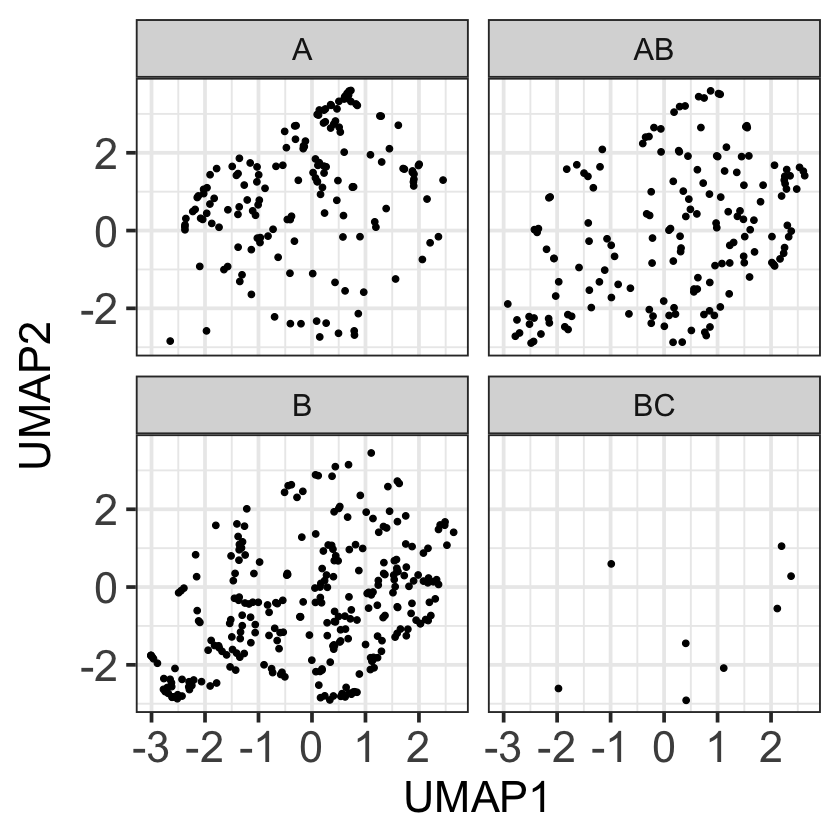

In [117]:
fig.size(7, 7)
#Merge it all together and look at per genotype distribution
CD45_filt %>% inner_join(read_csv("RNA_ADT_Barcodes.csv")) %>% mutate(cell = paste0(RNA_cell, "_",RNA_Barcode)) %>% select(plate_well, cell) %>% unique %>% 
inner_join(CD45_gen) %>% inner_join(meta_umap_adt_CD45.clust) %>% add_count(AllelicGenotype) %>% filter(n>5) %>%


ggplot()+
    geom_point(aes(x= UMAP1, y = UMAP2) )+
  theme_gy() + 
theme(legend.position = "right")+
labs(color = "Genotype") +
facet_wrap(. ~ AllelicGenotype)

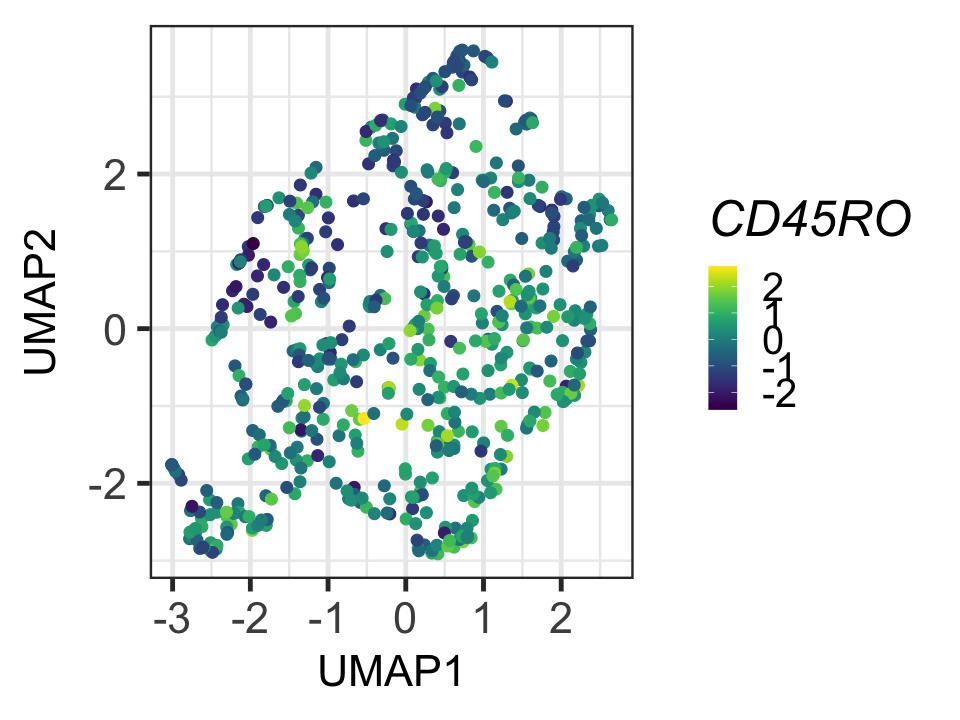

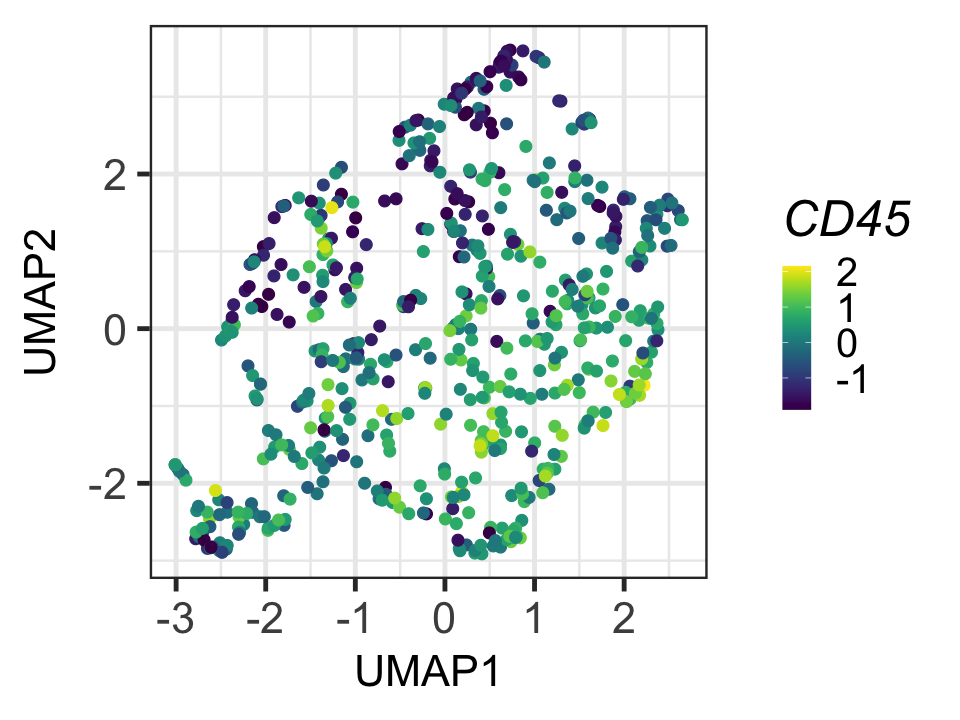

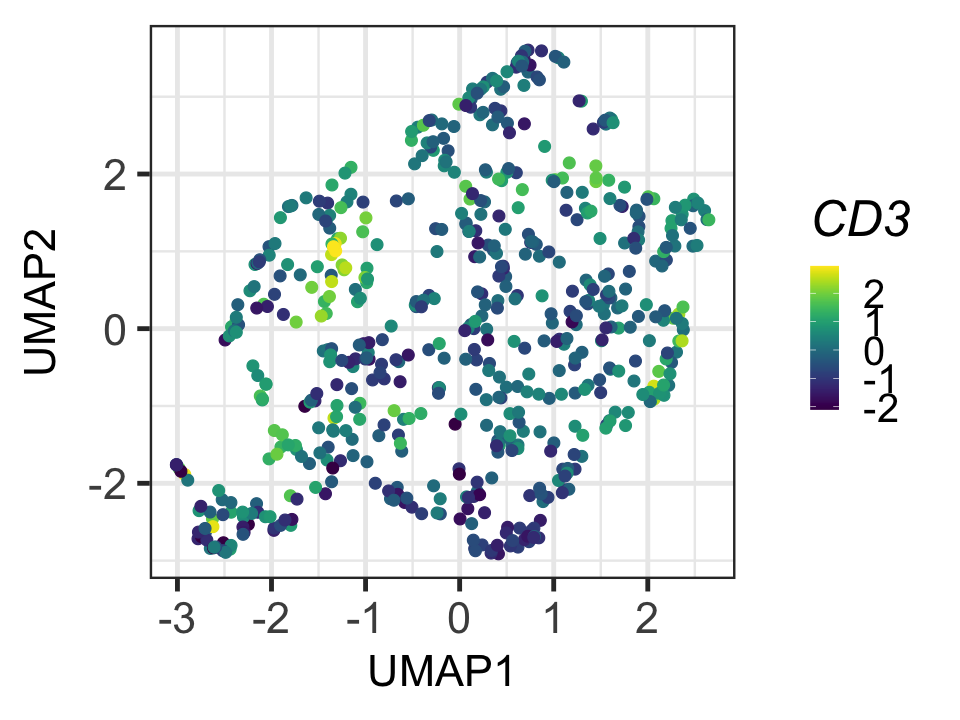

In [106]:
plot_exprs(scale_adt, meta_umap_adt_CD45, c("CD45RO", "CD45", "CD3"))

In [118]:
df<-meta_umap_adt_CD45.clust %>% arrange(cluster)
matrix <- scale_adt[,df$cell]

dge_CD45 = wilcoxauc(matrix, df$cluster)
var_genes_CD45 = top_markers(dge_CD45, 10) %>% head(10) %>% select(-rank) %>% 
                        unlist %>% unique 
cmax = abs(matrix[var_genes_CD45,]) %>% unlist %>% max #%>% quantile(.995)

# Data frame with column annotations.
mat_col <- data.frame(cluster = df$cluster)
rownames(mat_col) <- rownames(df)


# Sort dendogram
mat_cluster_cols <- hclust(dist(t(matrix[var_genes_CD45, ])))
mat_cluster_cols <- sort_hclust(mat_cluster_cols)
mat_cluster_rows <- sort_hclust(hclust(dist(matrix[var_genes_CD45, ])))

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Integrin_β7' in 'mbcsToSbcs': dot substituted for <ce>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Integrin_β7' in 'mbcsToSbcs': dot substituted for <b2>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'FcεRIα' in 'mbcsToSbcs': dot substituted for <ce>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'FcεRIα' in 'mbcsToSbcs': dot substituted for <b5>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'FcεRIα' in 'mbcsToSbcs': dot substituted for <ce>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'FcεRIα' in 'mbcsToSbcs': dot substituted for <b1>”
Warning message in grid.Call.graphics(C_text, as

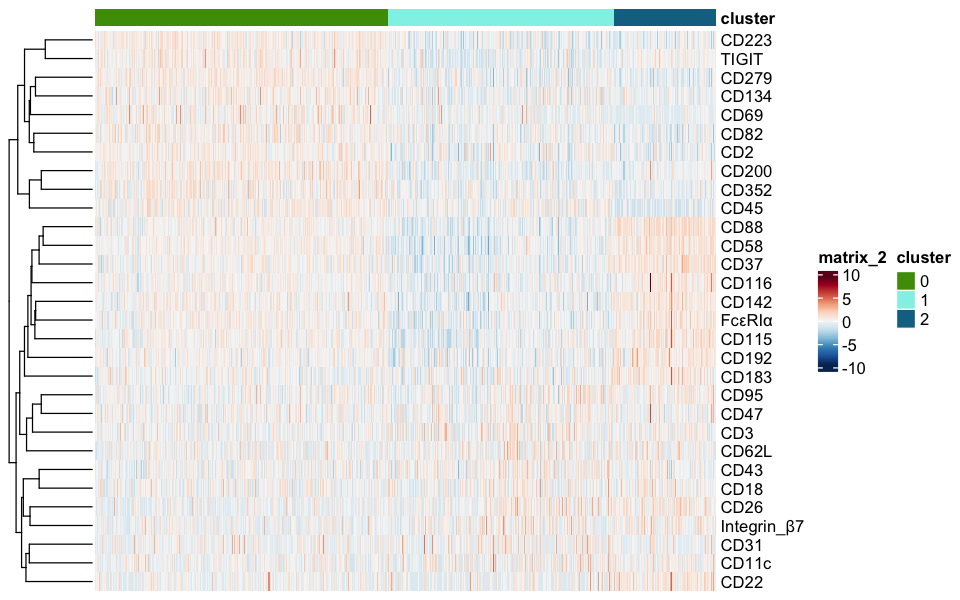

In [119]:
fig.size(5, 8)
pheatmap(as.matrix(matrix[c(var_genes_CD45), df$cell]),
         breaks = seq(-cmax, cmax, length.out = 100),
        color = colorRampPalette(brewer.pal(11, "RdBu"))(100) %>% rev,
        show_colnames = FALSE,
         annotation_col = mat_col, 
         fontsize = 10,
         cluster_cols = F,
         #annotation_colors = list(cluster = c(
         #                         `0` = "#66C2A5", 
          #                        `1` = "#FC8D62" 
                                  #`2` = "#8DA0CB"
           #                          )),
        cluster_rows = mat_cluster_rows,

        )

# Figures

In [120]:
CD45Plots <- read_csv("CD45Plots_Updated.csv")

Rows: 618 Columns: 32
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (16): Barcode_DNA, Well_ID, plate_well, genotype, AllelicGenotype, DNA_c...
dbl (16): PB_CD81, BV605_CD45, BV750_CD45, SSC, FSC, FITC_CD45, PE_CD81, PEC...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


## Bulk CD45

In [1774]:
read_csv("BulkCD45.csv")

Rows: 24 Columns: 6
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (3): Sample, Experiment, Status
dbl (3): PercentParent, CD4MFI, CD25MFI

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Sample  Experiment Status PercentParent CD4MFI CD25MFI
1  C0002YB CRISPR     Het    31.90         4361   2168   
2  C0002YB Control    Het     3.41         3975   1209   
3  C0004YB CRISPR     Het    37.70         4066   2755   
4  C0004YB Control    Het     7.84         3386   1188   
5  C0006YB CRISPR     Het    28.10         4254   1561   
6  C0006YB Control    Het    29.90         3808   1579   
7  C0010YB CRISPR     Het    26.10         4352   1300   
8  C0010YB Control    Het     2.54         3942   1232   
9  C0002YB CRISPR     WT     21.00         3641   2198   
10 C0002YB Control    WT     89.20         3678   1748   
11 C0004YB CRISPR     WT     35.60         3413   2676   
12 C0004YB Control    WT     76.20         3016   1884   
13 C0006YB CRISPR     WT     21.90         3568   2123   
14 C0006YB Control    WT     51.10         4032   2283   
15 C0010YB CRISPR     WT     19.20         3663   1835   
16 C0010YB Control    WT     89.50         3619   1902   
17 C0002YB CRISPR     KO     40.00         6146   2529   
18 C0002YB Control    KO      0.00            0      0   
19 C0004YB CRISPR     KO     19.90         5762   3312   
20 C0004YB Control    KO      0.00            0      0   
21 C0006YB CRISPR     KO     39.30         5604   1407   
22 C0006YB Control    KO      0.00            0      0   
23 C0010YB CRISPR     KO     46.20         5874   1462   
24 C0010YB Control    KO      0.01         3926   1464

Rows: 32 Columns: 6
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (3): Sample, Experiment, Status
dbl (3): PercentParent, CD4MFI, CD25MFI

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
“Removed 4 rows containing missing values (`stat_boxplot()`).”
Warning message:
“Removed 4 rows containing missing values (`geom_line()`).”
Warning message:
“Removed 4 rows containing missing values (`geom_point()`).”
Rows: 32 Columns: 6
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (3): Sample, Experiment, Status
dbl (3): PercentParent, CD4MFI, CD25MFI

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE

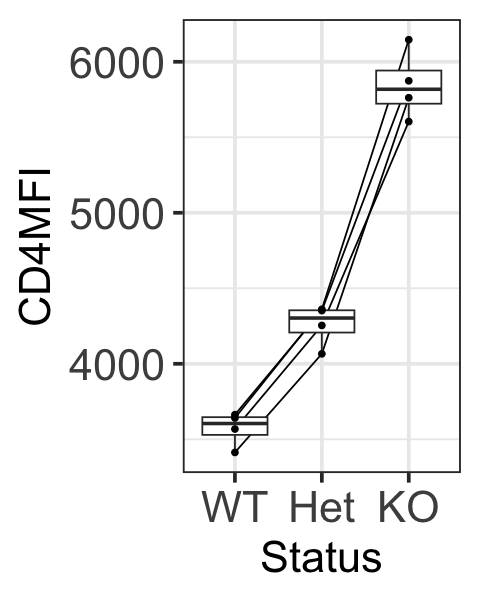

Rows: 32 Columns: 6
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (3): Sample, Experiment, Status
dbl (3): PercentParent, CD4MFI, CD25MFI

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


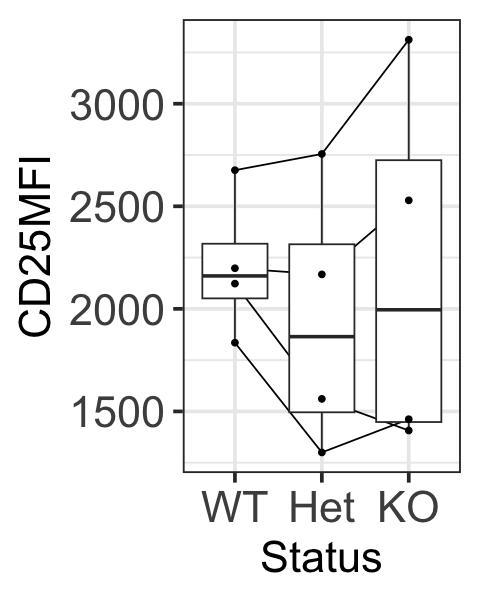

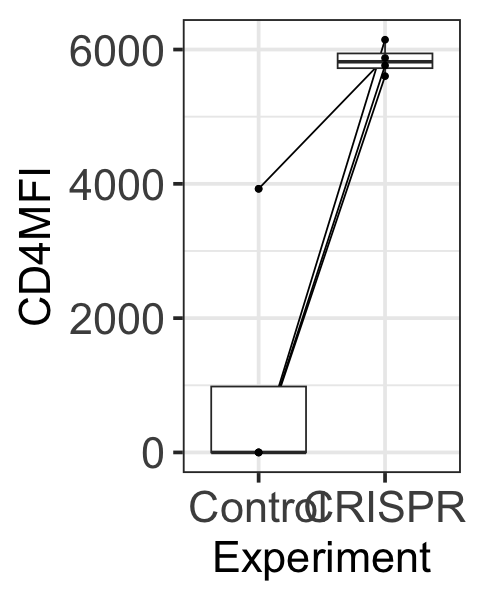

In [81]:
fig.size(5,4)
read_csv("BulkCD45.csv") %>% filter(Experiment == "CRISPR") %>%
ggplot(aes(Status, CD4MFI))  + 
geom_line(aes(group = Sample)) + geom_boxplot() + 
scale_x_discrete(limits = c("WT", "Het", "KO"))+ geom_point() + 
theme_gy() 

fig.size(5,4)
read_csv("BulkCD45.csv") %>% filter(Experiment == "CRISPR") %>%
ggplot(aes(Status, CD25MFI))  + 
geom_line(aes(group = Sample)) + geom_boxplot() + 
scale_x_discrete(limits = c("WT", "Het", "KO"))+ geom_point() + 
theme_gy() 

fig.size(5,4)
read_csv("BulkCD45.csv") %>% filter(Status == "KO") %>%
ggplot(aes(Experiment, CD4MFI))  + 
geom_line(aes(group = Sample)) + geom_boxplot() + geom_point() + 
theme_gy() 



In [ ]:
fig.size(5,4)
read_csv("BulkCD45.csv") %>% filter(Experiment == "CRISPR") %>%
ggplot(aes(Status, CD25MFI))  + 
geom_line(aes(group = Sample)) + geom_boxplot() + 
scale_x_discrete(limits = c("WT", "Het", "KO"))+ geom_point() + 
theme_gy() 

In [75]:
compare_means(CD25MFI~Experiment, BulkCD45)

.y.     group1 group2  p          p.adj p.format p.signif method  
1 CD25MFI CRISPR Control 0.01666011 0.017 0.017    *        Wilcoxon

## DNA

In [121]:
#Defineplotting Order
order <- CD45Plots$genotype %>% table %>% as_data_frame %>% arrange(`n`)
order <- as.character(order$`.`)

In [122]:
g <- CD45Plots %>% filter(genotype_count > 5) %>% dplyr::select(Barcode_DNA, Well_ID) %>% inner_join(CD45_filt) %>% Plotting_Alleles

Joining with `by = join_by(Barcode_DNA, Well_ID)`


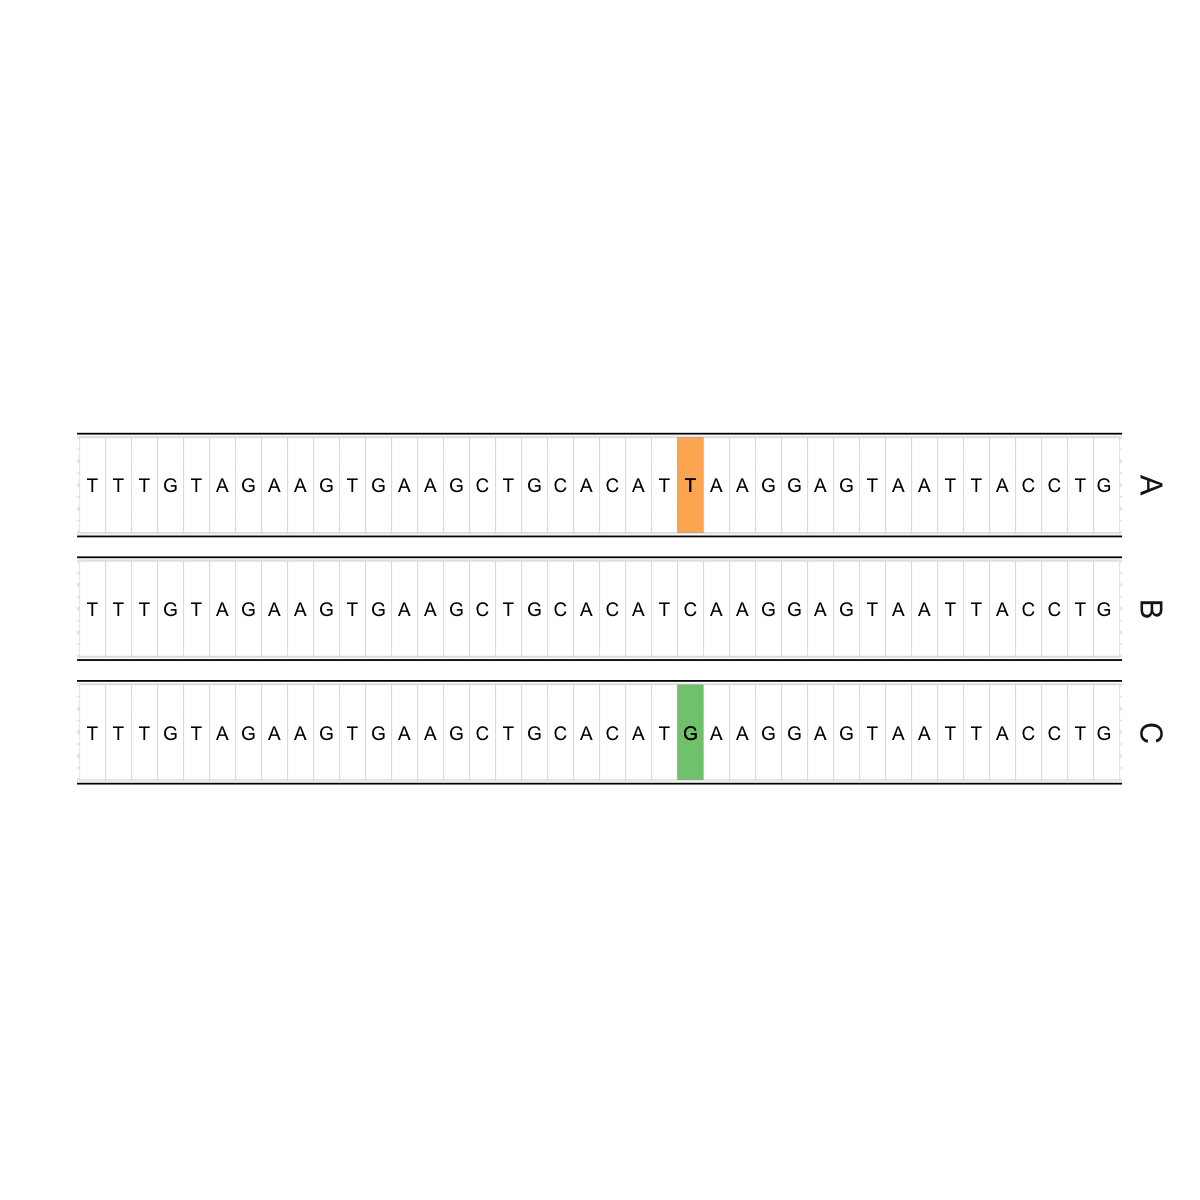

In [123]:
g

In [124]:
#Reorder!
g$data$genotypes <- factor(g$data$genotypes, levels = rev(c("B","A", "C", "D")))

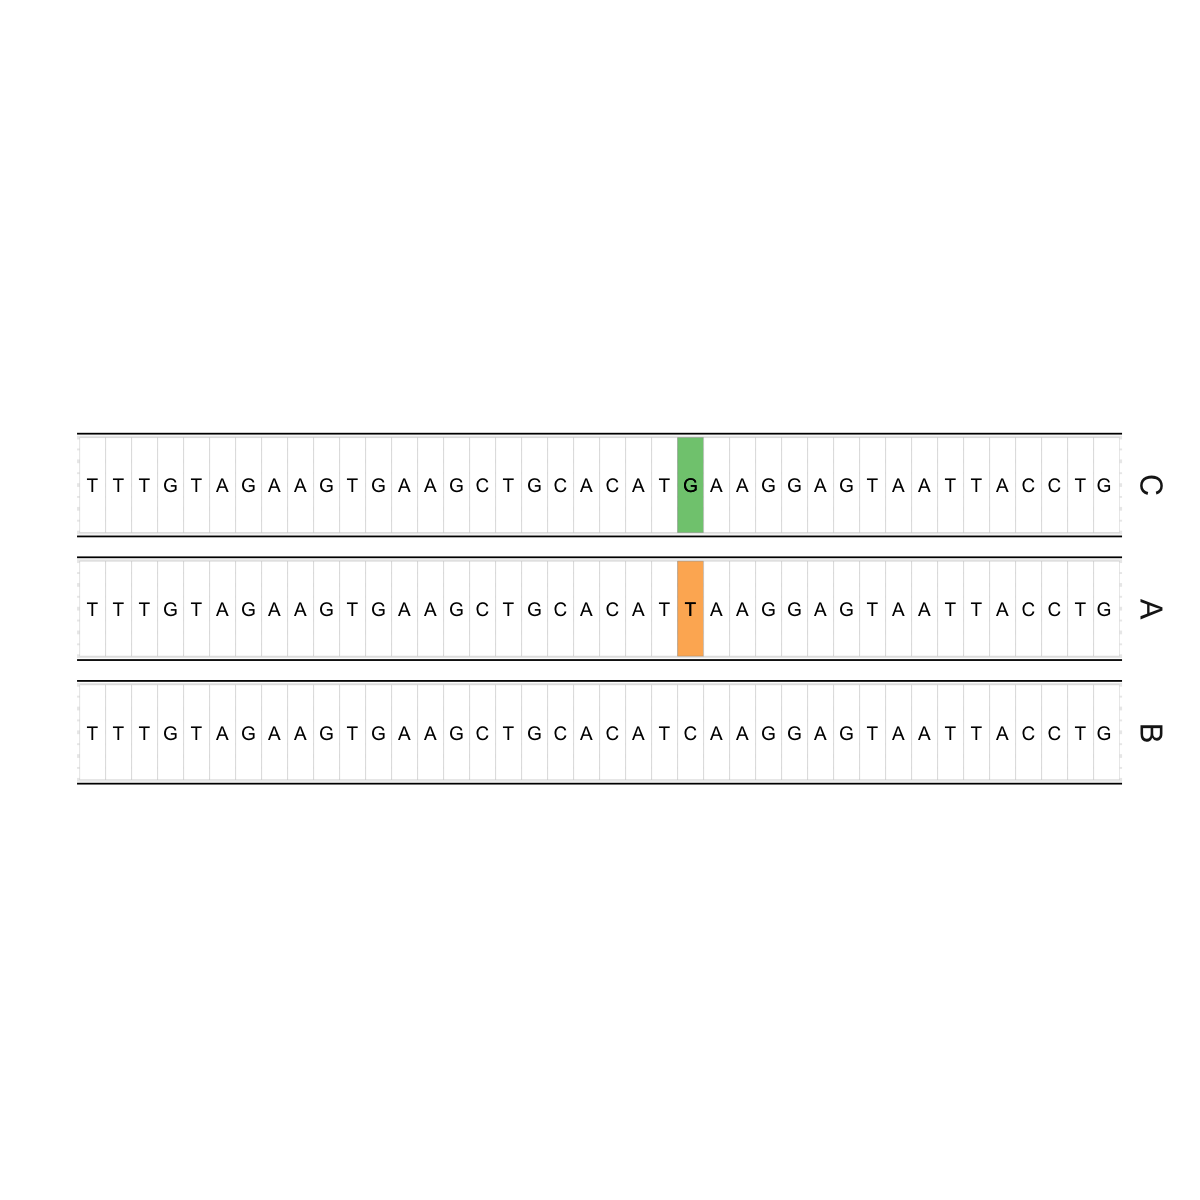

In [125]:
g

In [802]:
g %>% ggsave(filename = "CD45_Alleles.png")

Saving 7 x 7 in image
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“Unable to calculate text width/height (using zero)”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“Unable to calculate text width/height (using zero)”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“Unable to calculate text width/height (using zero)”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“Unable to calculate text width/height (using zero)”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“Unable to calculate text width/height (using zero)”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“Unable to calculate text width/height (using zero)”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“Unable to calculate text width/height (using zero)”
Warning message in grid.Call(C_te

`summarise()` has grouped output by 'as.factor(Edited_Index)', 'as.factor(Individual_Index)'. You can override using the `.groups` argument.
Joining with `by = join_by(genotype, Individual_Index, Edited_Index)`


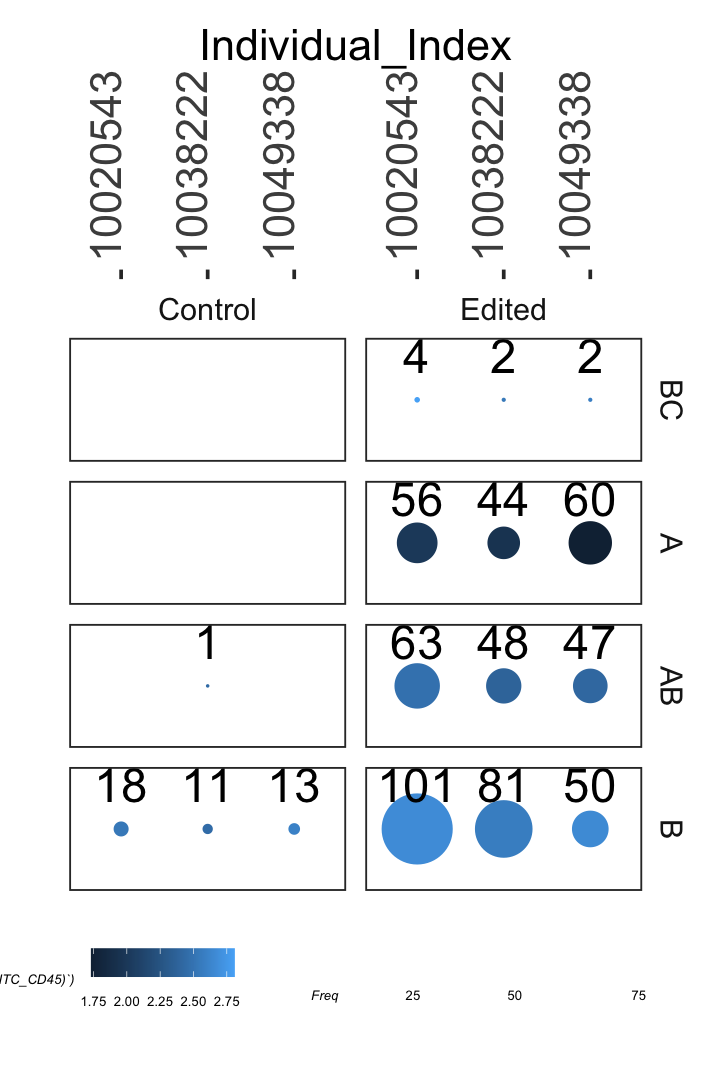

In [126]:
#Plotting number of cell per genotype and condition. 

test2 <- filter(CD45Plots, genotype_count >5) # Filter for > 5 cells per genotype

fig.size(9,6)
g <- 

table(test2$AllelicGenotype, test2$Individual_Index, test2$Edited_Index) %>% 
as.data.frame() %>% rename(Individual_Index = Var2, Edited_Index = Var3, genotype = Var1) %>% 
inner_join( 
test2 %>% group_by(as.factor(Edited_Index), as.factor(Individual_Index), as.factor(AllelicGenotype)) %>% 
    summarise(mean(FITC_CD45)) %>% rename(Individual_Index = `as.factor(Individual_Index)`, 
                                          Edited_Index = `as.factor(Edited_Index)`, genotype = `as.factor(AllelicGenotype)`)
)%>% na.omit%>% {
    
    ggplot(., aes(Individual_Index, 
                  fill = log10(`mean(FITC_CD45)`), size = Freq)) +
      geom_point(aes(y = 0),shape = 21, stroke = 0) +
      #geom_hline(yintercept = seq(.5, 4.5, 1), size = .2) +
  scale_x_discrete(position = "top") +
  scale_radius(range = c(1,20)) +
    geom_text(aes(y = 0, label = Freq), size =10, vjust = -0.8)+
  theme_gy() +
  theme(legend.position = "bottom", 
        panel.grid.major = element_blank(),
        legend.text = element_text(size = 8),
        legend.title = element_text(size = 8), 
       axis.text.x = element_text(angle = 90)) + 
    ylab("") + 
    scale_y_discrete(expand = c(0.1,0.5)) + 
    facet_grid(factor((genotype), levels = rev(c("B", "AB", "A", "BC")))~Edited_Index) + 
    theme(
  strip.background = element_blank(),
  #strip.text.x = element_blank(), 
    #panel.border=element_blank(), 
   # strip.text.y = element_blank()  
        )
} 
plot(g)
suppressWarnings({ 
    ggsave(g, filename = "g.png", device = "png", dpi = 300, width = 6, height = 9)
  })

In [127]:
## Plotting normalization
norm_adt <- singlecellmethods::normalizeData(counts_adt_filt, method = "cellCLR")
norm_exprs <- singlecellmethods::normalizeData(filt_exprs, method = "log")

Joining with `by = join_by(cell)`


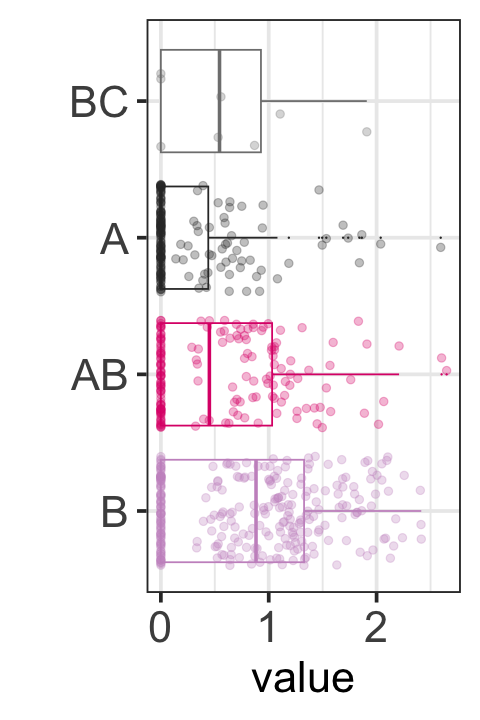

In [128]:
g <- 

norm_exprs["PTPRC",] %>% as_tibble(rownames = "cell") %>% inner_join(CD45Plots) %>%  
    filter(genotype_count >5) %>% na.omit() %>%

ggplot(aes(x = factor(AllelicGenotype, levels = (c("B", "AB", "A", "BC"))), 
           y = value, 
           color = factor(AllelicGenotype, levels = (c("B", "AB", "A", "BC"))))) + 
    geom_boxplot(outlier.size = 0) +
     geom_jitter(alpha = 0.3, size = 2) +   
    theme_gy() + 
theme(legend.position = "none")+ 
xlab("") + 
scale_color_manual(values =c( 
              "BC" = "grey50",
                  "7" = "grey50",
                  "BC" = "grey50",
                  "B" = "#C994C7",
                  "AB" = "#DD1C77", 
                  "A" = "grey20"))+ 

coord_flip()
fig.size(6,4)
plot(g)
## save plot
suppressWarnings({ 
    ggsave(g, filename = "g2.png", device = "png", dpi = 300, width = 4, height = 6)
    })


# RNA linear modeling

In [ ]:
### Excluding plate 1,  unreliable DNA data.

In [131]:
## Subsetting my Condition and fixing genotype. Removing BC genotype. (too few cells)
CD45Plots2 <- filter(CD45Plots, AllelicGenotype %in% c("A","AB","B")) %>% mutate(Dosage = ifelse(
AllelicGenotype == "B", 0, ifelse(AllelicGenotype == "A", 2, 1))) %>% filter(Edited_Index == "Edited") %>% na.omit 

In [132]:
CD45Plots3 <- filter(CD45Plots, AllelicGenotype %in% c("A","AB","B")) %>% mutate(Dosage = ifelse(
AllelicGenotype == "B", 0, ifelse(AllelicGenotype == "A", 2, 1))) %>% na.omit


## Linear Modeling

In [591]:
# Linear modeling. Negative binomial to Dosage. CRISPR condition only.
df <- CD45Plots2
cells <- df$cell
df$Individual_Index <- as.factor(df$Individual_Index)
df$Dosage %>% table
Exprs <- exprs[, df$cell] #expression in this set of cells

nCells = rowSums(Exprs > 0)
gene_qc = data.frame(nCells = nCells %>% sort %>% rev, rank = seq(1, length(nCells)))

Exprs <- filt_exprs[gene_qc %>% filter(nCells > length(cells)*0.15) %>% rownames, cells] #Expressed in 30% of cells. 
genes <- rownames(Exprs)

Exprs %>% dim
genes %>% length

suppressMessages({
    suppressWarnings({
CD45_lm_Dosage <- 
    sapply(genes, function(i){ 
        

    lm0<- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ 1 + log10(nUMI.y) + Plate + Individual_Index, 
            )
    
    lm1 <- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ 1  + log10(nUMI.y) + Plate + Individual_Index + Dosage, 
               )
    
     return(c(coefficients(lm1), "pval" = anova(lm0,lm1, test = "Chisq")[2,8]))
        })
    })
    })

CD45_lm_Dosage<- 
    t(CD45_lm_Dosage) %>% 
    as_tibble(rownames = "gene") %>% 
    mutate(padjBH = p.adjust(pval, method = "BH"))

.
  0   1   2 
232 158 160 

[1] 5511  550

[1] 5511

In [593]:
CD45_lm_Dosage %>% filter(padjBH < 0.05)

gene    (Intercept) log10(nUMI.y) PlateP3     PlateP4   
1 TNFRSF4  -4.197007  1.976669       0.05295609 0.14373288
2 TRBC2    -6.128260  2.293284       0.20030552 0.10967598
3 CHCHD10 -10.604930  2.744217      -0.15127065 0.07536001
4 PTPRC    -9.118225  2.445656       0.28734860 0.19386950
5 ANXA3   -13.432073  2.556328       0.28211425 0.02790393
  Individual_Index10038222 Individual_Index10049338 Dosage     pval        
1 -0.1779541                0.098516208             -0.2730704 2.585736e-06
2 -0.4028057               -0.068585180             -0.2459947 2.601048e-05
3 -0.2717936               -0.001834315              0.3580782 2.263081e-06
4 -0.2241544               -0.256680657             -0.6525851 5.551115e-16
5  0.9040109                0.343280105              0.8785004 2.275742e-08
  padjBH      
1 3.562498e-03
2 2.866875e-02
3 3.562498e-03
4 3.059220e-12
5 6.270806e-05

In [594]:
CD45_lm_Dosage%>% write_csv("CD45_lm_Dosage.csv") # export

In [595]:
CD45_lm_Dosage %>% filter(padjBH < 0.05) %>% arrange(pval) # PTPRC is the top hit. Makes sense.

gene    (Intercept) log10(nUMI.y) PlateP3     PlateP4   
1 PTPRC    -9.118225  2.445656       0.28734860 0.19386950
2 ANXA3   -13.432073  2.556328       0.28211425 0.02790393
3 CHCHD10 -10.604930  2.744217      -0.15127065 0.07536001
4 TNFRSF4  -4.197007  1.976669       0.05295609 0.14373288
5 TRBC2    -6.128260  2.293284       0.20030552 0.10967598
  Individual_Index10038222 Individual_Index10049338 Dosage     pval        
1 -0.2241544               -0.256680657             -0.6525851 5.551115e-16
2  0.9040109                0.343280105              0.8785004 2.275742e-08
3 -0.2717936               -0.001834315              0.3580782 2.263081e-06
4 -0.1779541                0.098516208             -0.2730704 2.585736e-06
5 -0.4028057               -0.068585180             -0.2459947 2.601048e-05
  padjBH      
1 3.059220e-12
2 6.270806e-05
3 3.562498e-03
4 3.562498e-03
5 2.866875e-02

In [596]:
# Linear model to Condition. 
df <- CD45Plots3
cells <- df$cell
df$Individual_Index <- as.factor(df$Individual_Index)
df$Dosage %>% table
Exprs <- exprs[, df$cell] #expression in this set of cells

nCells = rowSums(Exprs > 0)
gene_qc = data.frame(nCells = nCells %>% sort %>% rev, rank = seq(1, length(nCells)))

Exprs <- filt_exprs[gene_qc %>% filter(nCells > length(cells)*0.15) %>% rownames, cells] #Expressed in 15% of cells. 
genes <- rownames(Exprs)
Exprs %>% dim

suppressMessages({
    suppressWarnings({
CD45_lm_Bulk <- 
    sapply(genes, function(i){ 
        

    lm0<- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ 1 + log10(nUMI.y) + Plate + Individual_Index, 
            )
    
    lm1 <- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ 1  + log10(nUMI.y) + Plate + Individual_Index + Edited_Index, 
               )
    
     return(c(coefficients(lm1), "pval" = anova(lm0,lm1, test = "Chisq")[2,8]))
        })
    })
    })

CD45_lm_Bulk<- 
    t(CD45_lm_Bulk) %>% 
    as_tibble(rownames = "gene") %>% 
    mutate(padjBH = p.adjust(pval, method = "BH"))

.
  0   1   2 
274 159 160 

[1] 5583  593

In [597]:
CD45_lm_Bulk %>% write_csv("CD45_lm_Bulk.csv")

## ADT modeling

In [606]:
# Linear model of ADT to Dosage. negative binomial. 

df <- CD45Plots2
df$Individual_Index <- as.factor(df$Individual_Index)
df$Dosage %>% table
Exprs <- counts_ADT_filt[, df$cell]
gene <- intersect(genes, rownames(Exprs))#defined above on variance to mean ratio
gene <- genes[-grep(genes, pattern = "^Ig")] #Remove Ig genes

Exprs %>% dim

suppressMessages({
    suppressWarnings({
CD45_lm_Dosage_adt <- 
    sapply(gene, function(i){ 
        

    lm0<- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ 1 + log10(nUMI.x) + Plate + Individual_Index, 
            )
    
    lm1 <- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ 1  + log10(nUMI.x) + Plate + Individual_Index + Dosage, 
               )
     return(c(coefficients(lm1), "pval" = anova(lm0,lm1, test = "Chisq")[2,8]))
        })
    })
    })

CD45_lm_Dosage_adt<- 
    t(CD45_lm_Dosage_adt) %>% 
    as_tibble(rownames = "gene") %>% 
    mutate(padjBH = p.adjust(pval, method = "BH"))

.
  0   1   2 
232 158 160 

[1] 154 550

In [608]:
CD45_lm_Dosage_adt %>% write_csv("CD45_lm_Dosage_adt.csv")

In [607]:
CD45_lm_Dosage_adt %>% arrange(padjBH,Dosage) %>% filter(padjBH < 0.05) # Lotta hits. CD45 is the top. 

gene             (Intercept) log10(nUMI.x) PlateP3     PlateP4    
1  CD45              -1.8723572 1.4266674      0.44372596  0.61880528
2  CD45RO            -1.7274590 1.8477939      0.16104698  0.16260710
3  CD45RA            -2.8131215 1.3465740      0.26195248  0.29808833
4  CD4               -4.1362242 2.0724890      0.09305513  0.05493361
5  CD37              -7.7258942 2.6543479     -0.10372331 -0.01891489
6  CD134             -3.5624129 2.2200321      0.07251314  0.02256254
7  CD88              -6.7192251 2.6233476     -0.07790305 -0.04928804
8  CD56              -4.2296093 1.3725877      0.65719579  0.73200143
9  CD8               -9.3655728 2.6628598     -0.02773827 -0.39406213
10 HLADR             -9.5145659 3.0991822      0.02248979  0.29938097
11 CD28              -7.0037282 2.2557556     -0.24369395 -0.19295506
12 CD183             -4.9020205 2.2114955     -0.06262671 -0.11142642
13 CD57_Recombinant  -0.3364118 0.3492036      1.72228146  1.13485478
14 CD69              -5.5750182 2.1417305      0.04483674  0.05755921
15 CD18              -4.8800963 1.6828490      0.15187773 -0.01099653
16 CD279             -1.6059863 2.1366718      0.07175332  0.04838661
17 CD137             -7.2006827 2.6349405      0.01148951  0.26077192
18 CD26              -4.1521350 1.7948961      0.37205652  0.49164559
19 CD73              -2.8526481 1.5910731      0.12818859  0.18862341
20 CD58              -4.7519923 2.3293882      0.01799993  0.02418061
21 CD150             -2.8493775 1.8348007      0.15597834  0.15964852
22 CD101             -6.4266739 1.9993966      0.22825220  0.35796923
23 GPR56             -5.6767418 2.1679417     -0.30261452 -0.13908561
24 CD11a             -4.9342837 1.8216778      0.22995876  0.19243743
25 CD25              -3.3719288 1.9265977      0.23186850  0.21751362
26 CD22             -10.3056451 2.8970312     -0.29665510 -0.08175953
27 CD192             -6.3242055 2.2629303     -0.05505725 -0.03125025
28 Integrin_β7       -3.6877104 1.8067720      0.22589235 -0.03521374
29 CD23              -5.9886713 2.1395518      0.03676390  0.05547648
30 CD43              -2.2931318 1.4972000      0.24027659  0.12419566
31 CD48              -2.6181692 1.7777362      0.19490555  0.12622035
32 CD223             -3.2211747 2.5307633      0.03512183 -0.07675370
33 CD109             -3.6348551 1.9663884      0.31167878  0.20004914
34 CD81              -6.3896653 2.2886816      0.04236024  0.04391269
35 CD7               -4.8477981 2.0447423      0.19831044  0.30171077
36 CD172a            -7.8502234 2.4224202     -0.02784820  0.02230303
   Individual_Index10038222 Individual_Index10049338 Dosage      pval        
1  -0.066425401             -0.273852387             -0.80469451 0.000000e+00
2  -0.150790637             -0.148539053             -0.66459389 0.000000e+00
3   0.073343324             -0.020494107             -0.49233375 0.000000e+00
4   0.131211265             -0.191142812              0.29093164 0.000000e+00
5  -0.058577403             -0.102967189              0.12633770 3.089372e-09
6  -0.105662575              0.154150104             -0.13478855 4.764480e-07
7  -0.108881067             -0.074695589              0.08894944 6.300501e-07
8   0.524453689              0.030722662             -0.31885811 1.573602e-06
9  -0.041237426              0.142493415             -0.36100527 3.957550e-06
10  0.305773263              0.010207086             -0.23980465 3.895943e-06
11 -0.116139277             -0.211185166              0.17692039 3.553328e-06
12 -0.178347862              0.091409806              0.11239336 4.795046e-06
13  0.385750471             -0.023349527             -0.34548546 1.063929e-05
14 -0.417840686              0.027775692             -0.25935714 2.130251e-05
15  0.192957481             -0.184269479              0.15533390 5.803101e-05
16  0.197630169              0.231059885             -0.11649354 1.154455e-04
17  0.287392716              0.111996046             -0.14475231 1.677868e-04
18 -0.015

Joining with `by = join_by(cell)`
Joining with `by = join_by(cell)`


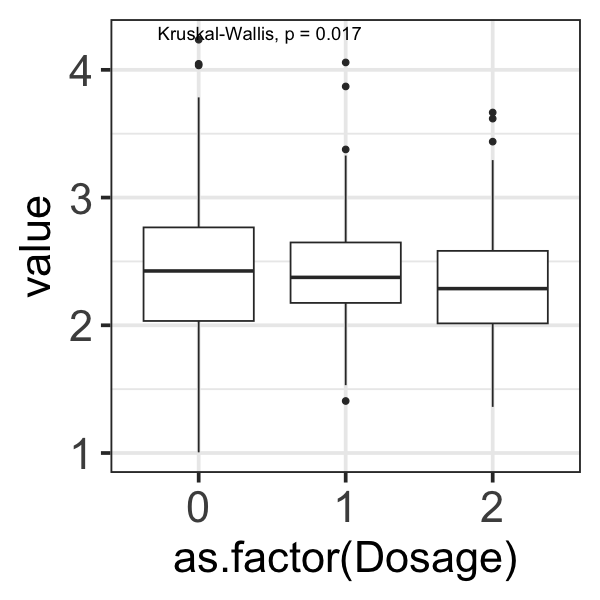

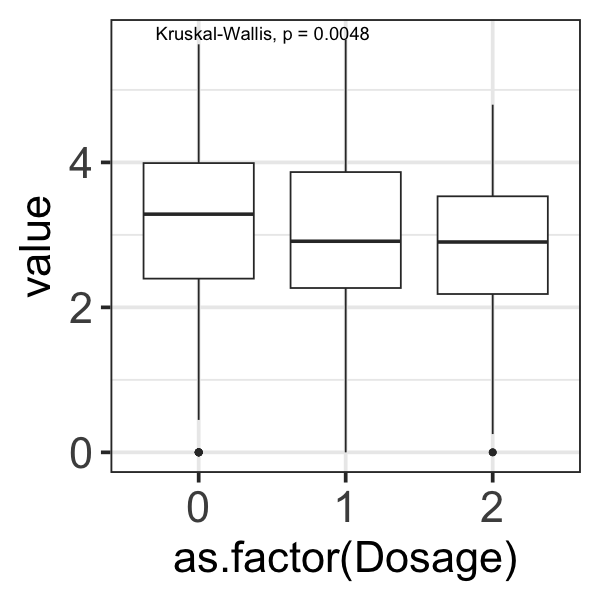

In [133]:
fig.size(5,5) ## Magnificent corelation of protein and genotype!!! 
norm_adt["CD134",] %>% as_tibble(rownames = "cell") %>% inner_join(CD45Plots2) %>% 
ggplot(aes(as.factor(Dosage), value)) + geom_boxplot() + theme_gy() + stat_compare_means()

norm_exprs["TNFRSF4",] %>% as_tibble(rownames = "cell") %>% inner_join(CD45Plots2) %>% 
ggplot(aes(as.factor(Dosage), value)) + geom_boxplot() + theme_gy()+ stat_compare_means()

In [610]:
# Linear model to Condition

df <- CD45Plots3
df$Individual_Index <- as.factor(df$Individual_Index)
df$Dosage %>% table
Exprs <- counts_ADT_filt[, df$cell]
gene <- intersect(genes, rownames(Exprs))#defined above on variance to mean ratio
gene <- genes[-grep(genes, pattern = "^Ig")] #Remove Ig genes

Exprs %>% dim

suppressMessages({
    suppressWarnings({
CD45_lm_Edited_adt <- 
    sapply(genes, function(i){ 
        

    lm0<- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ 1 + log10(nUMI.x) + Plate + Individual_Index, 
            )
    
    lm1 <- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ 1  + log10(nUMI.x) + Plate + Individual_Index + Edited_Index, 
               )
     return(c(coefficients(lm1), "pval" = anova(lm0,lm1, test = "Chisq")[2,8]))
        })
    })
    })

CD45_lm_Edited_adt<- 
    t(CD45_lm_Edited_adt) %>% 
    as_tibble(rownames = "gene") %>% 
    mutate(padjBH = p.adjust(pval, method = "BH"))

.
  0   1   2 
274 159 160 

[1] 154 593

In [71]:
CD45_lm_Edited_adt %>% write_csv("CD45_lm_Edited_adt.csv")

In [612]:
CD45_lm_Edited_adt %>% arrange(padjBH)

gene             (Intercept) log10(nUMI.x) PlateP3       PlateP4     
1   CD25              -3.8542193 1.9670867      0.176997507   0.183007936
2   CD62L             -2.4697693 1.8737337      0.410409345   0.088194572
3   CD279             -1.9522250 2.1033016      0.077520005   0.054592003
4   CD7               -5.2269021 2.0469128      0.185514696   0.320033022
5   CD28              -6.5876095 2.2945611     -0.194630749  -0.152152196
6   GPR56             -6.1439764 2.1043726     -0.268649049  -0.130509886
7   CD4               -4.6826928 2.2124090      0.058002127   0.047110057
8   CD72              -4.7728105 1.5861629      0.331212773   0.308548185
9   CD55              -3.1126513 1.9574564     -0.031108909  -0.037156317
10  CD45RO            -1.2888608 1.7192226      0.195521579   0.045262015
11  HLADR            -10.3290160 3.1560847     -0.033285488   0.215338044
12  CD38              -2.9504496 1.7960054      0.350648340   0.297585534
13  Integrin_β7       -3.6959445 1.9779763      0.085475469  -0.146060114
14  CD335             -7.6079538 2.3465829      0.078556064  -0.040983602
15  CD47              -5.3775573 2.0062301      0.016132659  -0.008863703
16  CD274             -8.2914370 2.8949149     -0.047786285  -0.047590522
17  CD278             -3.8005387 2.3750559      0.003674684   0.156760929
18  CD57_Recombinant  -0.4672529 0.1420787      1.887035503   1.224301722
19  CD123             -7.8666798 2.6173216      0.038646832   0.397305294
20  CD137             -7.2308718 2.5347719      0.024917832   0.258683159
21  CD99              -2.3175758 1.8816778      0.147107163   0.119688975
22  CD44              -4.1177402 1.7510402      0.244465024   0.274750181
23  CD73              -3.1150522 1.5080893      0.170011848   0.140355032
24  CD54              -2.8991711 1.9897076      0.065477837   0.128602960
25  CD226             -6.6716170 2.2605639      0.211145150   0.241251730
26  IgD               -8.8134514 2.6999803     -0.207254994  -0.240326852
27  CD2               -4.2667437 1.9351977      0.149040190   0.071299154
28  CD304             -3.2797206 1.3604460      0.035456676   0.148871023
29  CD22              -9.9358691 2.9209835     -0.353933602  -0.136433563
30  CD13              -8.2400592 2.3031201     -0.215485345  -0.138935186
⋮   ⋮                ⋮           ⋮             ⋮             ⋮           
121 CD127             -7.332218  2.346291      -0.0675749917  0.083608044
122 TCR_Vdelta2       -8.375096  2.344077       0.0181547062 -0.205419758
123 CD29              -3.538944  1.797284       0.1800418431  0.181664127
124 CD192             -6.425111  2.309099      -0.0530891892 -0.044484835
125 CD328             -5.588652  1.286701       0.4975572627  0.279087468
126 Ig_K              -6.241677  2.389898       0.0741972713  0.035706754
127 CD84              -5.696736  2.130938      -0.0003155757 -0.059622670
128 CD142             -6.136817  2.404845       0.0205701479  0.015660939
129 CD101             -6.265546  2.023094       0.1431484254  0.276795614
130 CD48              -2.815352  1.843359       0.1794842856  0.129882150
131 CD11a             -5.141502  1.899998       0.1823388842  0.156866798
132 CD20             -10.531676  1.636674       1.0719292391 -0.736862854
133 IgM               -6.781378  2.353504       0.0102437983 -0.019870664
134 CD244             -6.922337  1.991209       0.3081019582  0.180995253
135 CD196             -7.326302  2.167217       0.0468120493  0.012519212
136 CD267             -6.955686  2.378218       0.0788349589  0.120105275
137 CD64              -8.958276  2.395110      -0.1327624822 -0.231899882
138 CD23              -6.215880  2.218443      -0.0042980795  0.054073972
139 FcεRIα            -7.835001  2.663486      -0.0153139959 -0.036806985
140 CD103             -3.874905  1.446269       0.3346751294  0.285887325
141 CD32              -7.723319  2.225520      -0.1151093772  0.031834445
142 CD61             -11.180671  2.688979      -0.1061182884  0.007577723
143 CD11

## Differential Gene and Protein Combination.

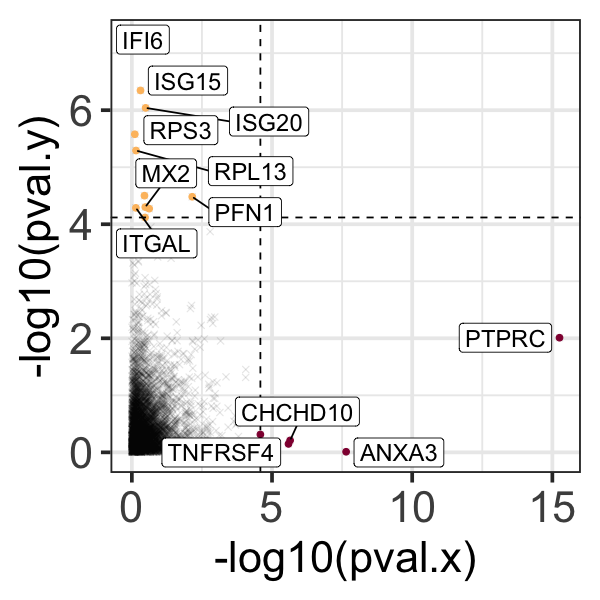

In [620]:
fig.size(5,5)
inner_join(CD45_lm_Dosage  %>% mutate(Condition = "Dosage"),
CD45_lm_Bulk %>% mutate(Condition = "Edited"), by = "gene") %>% 

{
ggplot(data = ., aes(-log10(pval.x), -log10(pval.y))) + 
    geom_point(alpha = 0.1, shape = 4)+
    geom_point(data = filter(`.`, padjBH.x < 0.05), color = "#91003F") +
     geom_point(data = filter(`.`, padjBH.y < 0.05), color = "#FDBF6E") +
    theme_gy() + 
    geom_vline(xintercept = -log10( 
    CD45_lm_Dosage %>% filter(padjBH < 0.05) %>% arrange(-pval) %>% head(1) %>% with(pval)
    ), linetype = 2) + 
    geom_hline(yintercept =  -log10( 
    CD45_lm_Bulk %>% filter(padjBH < 0.05) %>% arrange(-pval) %>% head(1) %>% with(pval)
    ), linetype = 2) + 
    geom_label_repel(data = filter(`.`, padjBH.x < 0.01), aes(label = gene), size  =5) +
     geom_label_repel(data = filter(`.`, padjBH.y < 0.05), aes(label = gene), size  =5)
    
    }

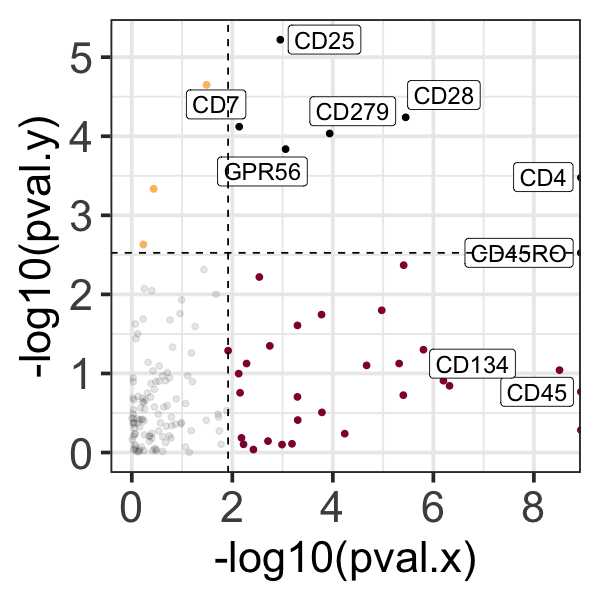

In [621]:
fig.size(5,5)
inner_join(CD45_lm_Dosage_adt  %>% mutate(Condition = "Dosage"),
CD45_lm_Edited_adt %>% mutate(Condition = "Edited"), by = "gene") %>% 

{
ggplot(data = ., aes(-log10(pval.x), -log10(pval.y)))  +
    geom_point(alpha = 0.1)+
    geom_point(data = filter(`.`, padjBH.x < 0.05 & padjBH.y > 0.05), color = "#91003F") +
     geom_point(data = filter(`.`, padjBH.y < 0.05 & padjBH.x > 0.05), color = "#FDBF6E") +
    geom_point(data = filter(`.`, padjBH.y < 0.05 & padjBH.x < 0.05), color = "black")+
    theme_gy()+
     #geom_label_repel(data = filter(`.`, padjBH.x < 0.05 & padjBH.y > 0.05), aes(label = Gene)) +
     #geom_label_repel(data = filter(`.`, padjBH.y < 0.05 & padjBH.x > 0.05), aes(label = Gene)) + 
     geom_label_repel(data = filter(`.`, padjBH.y < 0.05 & padjBH.x < 0.05), aes(label = gene), size  =5) +
    geom_vline(xintercept = -log10( 
    CD45_lm_Dosage_adt %>% filter(padjBH < 0.05) %>% arrange(-pval) %>% head(1) %>% with(pval)
    ), linetype = 2) + 
    geom_hline(yintercept =  -log10( 
    CD45_lm_Edited_adt %>% filter(padjBH < 0.05) %>% arrange(-pval) %>% head(1) %>% with(pval)
    ), linetype = 2) + 
    geom_label_repel(data = filter(`.`,gene == "CD45"), aes(label = gene), size  =5)+ 
    geom_label_repel(data = filter(`.`,gene == "CD134"), aes(label = gene), size  =5)
    
    }

In [623]:
#Function for creating heatmap plots of significant genes from scaled exprs 
##Define gene set. 
sig_genes_Dosage <- CD45_lm_Dosage %>% filter(padjBH < 0.05) %>% top_n(5, wt=-pval) %>% with(gene) # select top 5
sig_genes_Edited<- CD45_lm_Bulk %>% filter(padjBH < 0.05) %>% top_n(5, wt=-pval) %>%  with(gene) # select top 5
sig_genes <- union(sig_genes_Dosage,sig_genes_Edited)
#Scale data
scale_exprs <- exprs %>% normalizeData(method = "log") %>% scaleData()

#Pull out data and pivot longer. 
df<- CD45Plots3 %>% filter(Edited_Index == "Edited") %>% 
    mutate(group = paste0(Dosage,"_", Individual_Index)) %>% 
    dplyr::select(cell, group) %>% 
    inner_join(t(scale_exprs[sig_genes, CD45Plots3$cell]) %>%
                   as_tibble(rownames = "cell")) %>% 
    group_by(group) %>% 
    summarise_all(.funs = mean) %>% 
    dplyr::select(-cell) %>% 
    pivot_longer(-group) 

df2 <- CD45Plots3 %>%
    mutate(group = paste0(Edited_Index,"_", Individual_Index)) %>%
    dplyr::select(cell, group) %>% 
    inner_join(t(scale_exprs[sig_genes, CD45Plots3$cell]) %>%
                   as_tibble(rownames = "cell")) %>% 
    group_by(group) %>% 
    summarise_all(.funs = mean) %>% 
    dplyr::select(-cell) %>% 
    pivot_longer(-group) 

#rename dfs
colnames(df) <- c("X", "gene", "value")
colnames(df2) <- c("X", "gene", "value")

#Order geneset
test <- scale_exprs[sig_genes_Dosage, CD45Plots3$cell] %>% dist %>% hclust
test2 <- scale_exprs[sig_genes_Edited, CD45Plots3$cell] %>% dist %>% hclust
order <- union(sig_genes_Dosage[test$order], sig_genes_Edited[test2$order])

Joining with `by = join_by(cell)`
Warning message:
“There were 9 warnings in `summarise()`.
The first warning was:
ℹ In argument: `cell = (new("standardGeneric", .Data = function (x, ...) ...`.
ℹ In group 1: `group = "0_10020543"`.
Caused by warning in `mean.default()`:
! argument is not numeric or logical: returning NA
ℹ Run `dplyr::last_dplyr_warnings()` to see the 8 remaining warnings.”
Joining with `by = join_by(cell)`
Warning message:
“There were 6 warnings in `summarise()`.
The first warning was:
ℹ In argument: `cell = (new("standardGeneric", .Data = function (x, ...) ...`.
ℹ In group 1: `group = "Control_10020543"`.
Caused by warning in `mean.default()`:
! argument is not numeric or logical: returning NA
ℹ Run `dplyr::last_dplyr_warnings()` to see the 5 remaining warnings.”


Saving 7 x 7 in image


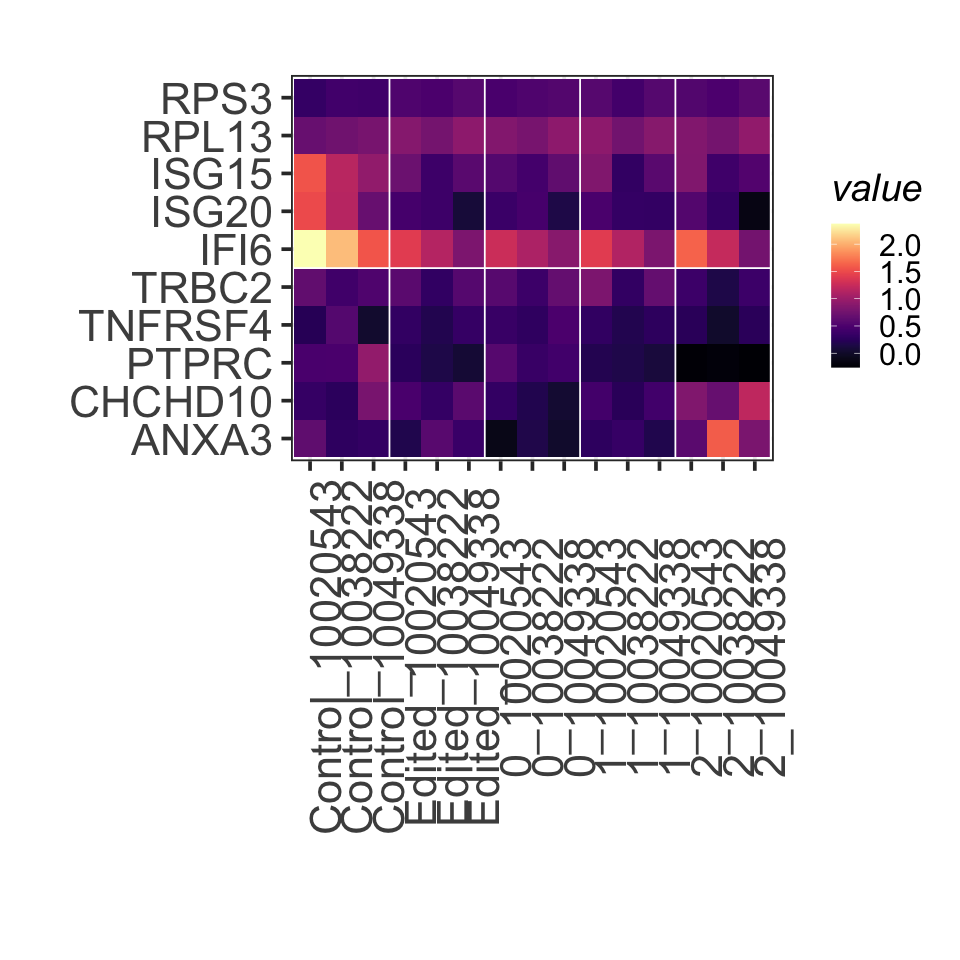

In [624]:
#Plot Figure
fig.size(8,8)
g<-  ggplot() + 
geom_tile(data = df,
          aes(x = X, y = gene, fill = value)) + 
geom_tile(data = df2,
          aes(x = X, y = gene, fill = value)) + 
scale_fill_viridis(option = "magma") + 
theme_gy() + 
scale_y_discrete(limits = c(order)) + 
theme(axis.text.x = element_text(angle = 90)) + 
scale_x_discrete(limits = c(unique(df2$X),unique(df$X))) + 
theme(legend.position = "right") + 
geom_vline(xintercept = c(3.5, 6.5, 9.5,12.5,15.5), color = "white")+
geom_hline(yintercept = sum(sig_genes %in% sig_genes_Dosage)+0.5, color = "white") + 
xlab("") + ylab("")+ 
theme(aspect.ratio = 0.8)

plot(g)
## save the plot
suppressWarnings({ 
    ggsave(g, filename = "g.png", device = "png", dpi = 300)
    })

In [ ]:
## Exact same analysis, but with adt

In [625]:
#Extract ADTs
sig_genes_Dosage_adt <- CD45_lm_Dosage_adt %>% filter(padjBH < 0.05) %>% top_n(wt = -pval, n = 5) %>% with(gene)
sig_genes_Edited_adt<- CD45_lm_Edited_adt %>% filter(padjBH < 0.05) %>% top_n(wt = -pval,n = 5) %>% with(gene)

## gotta manually filter some ADTs that don't make sense. 
sig_genes_Dosage_adt<-
sig_genes_Dosage_adt[!grepl(sig_genes_Dosage_adt, pattern = "Ig")]
sig_genes_Edited_adt <- sig_genes_Edited_adt[!grepl(sig_genes_Edited_adt, pattern = "Ig")]
sig_genes_adt <- union(sig_genes_Dosage_adt,sig_genes_Edited_adt)

#Assign Ordering 
test <- scale_adt[sig_genes_Dosage_adt, CD45Plots3$cell] %>% dist %>% hclust
test2 <- scale_adt[sig_genes_Edited_adt, CD45Plots3$cell] %>% dist %>% hclust
order_adt <- union(sig_genes_Dosage_adt[test$order], sig_genes_Edited_adt[test2$order])

#Define data sets
df_adt<- CD45Plots3 %>% filter(Edited_Index == "Edited") %>% 
    mutate(group = paste0(Dosage,"_", Individual_Index)) %>% 
    dplyr::select(cell, group) %>% 
    inner_join(t(scale_adt[sig_genes_adt, CD45Plots3$cell]) %>%
                   as_tibble(rownames = "cell")) %>% 
    group_by(group) %>% 
    summarise_all(.funs = mean) %>% 
    dplyr::select(-cell) %>% 
    pivot_longer(-group) 

df2_adt <- CD45Plots3 %>%
    mutate(group = paste0(Edited_Index,"_", Individual_Index)) %>%
    dplyr::select(cell, group) %>% 
    inner_join(t(scale_adt[sig_genes_adt, CD45Plots3$cell]) %>%
                   as_tibble(rownames = "cell")) %>% 
    group_by(group) %>% 
    summarise_all(.funs = mean) %>% 
    dplyr::select(-cell) %>% 
    pivot_longer(-group) 

colnames(df_adt) <- c("X", "gene", "value")
colnames(df2_adt) <- c("X", "gene", "value")

Joining with `by = join_by(cell)`
Warning message:
“There were 9 warnings in `summarise()`.
The first warning was:
ℹ In argument: `cell = (new("standardGeneric", .Data = function (x, ...) ...`.
ℹ In group 1: `group = "0_10020543"`.
Caused by warning in `mean.default()`:
! argument is not numeric or logical: returning NA
ℹ Run `dplyr::last_dplyr_warnings()` to see the 8 remaining warnings.”
Joining with `by = join_by(cell)`
Warning message:
“There were 6 warnings in `summarise()`.
The first warning was:
ℹ In argument: `cell = (new("standardGeneric", .Data = function (x, ...) ...`.
ℹ In group 1: `group = "Control_10020543"`.
Caused by warning in `mean.default()`:
! argument is not numeric or logical: returning NA
ℹ Run `dplyr::last_dplyr_warnings()` to see the 5 remaining warnings.”


In [633]:
#adjust order of ADT because of shared. 
order_adt <- c('CD37','CD45RA','CD45','CD45RO','CD4','CD279','CD7','CD25', "CD62L", "CD28")

Saving 7 x 7 in image


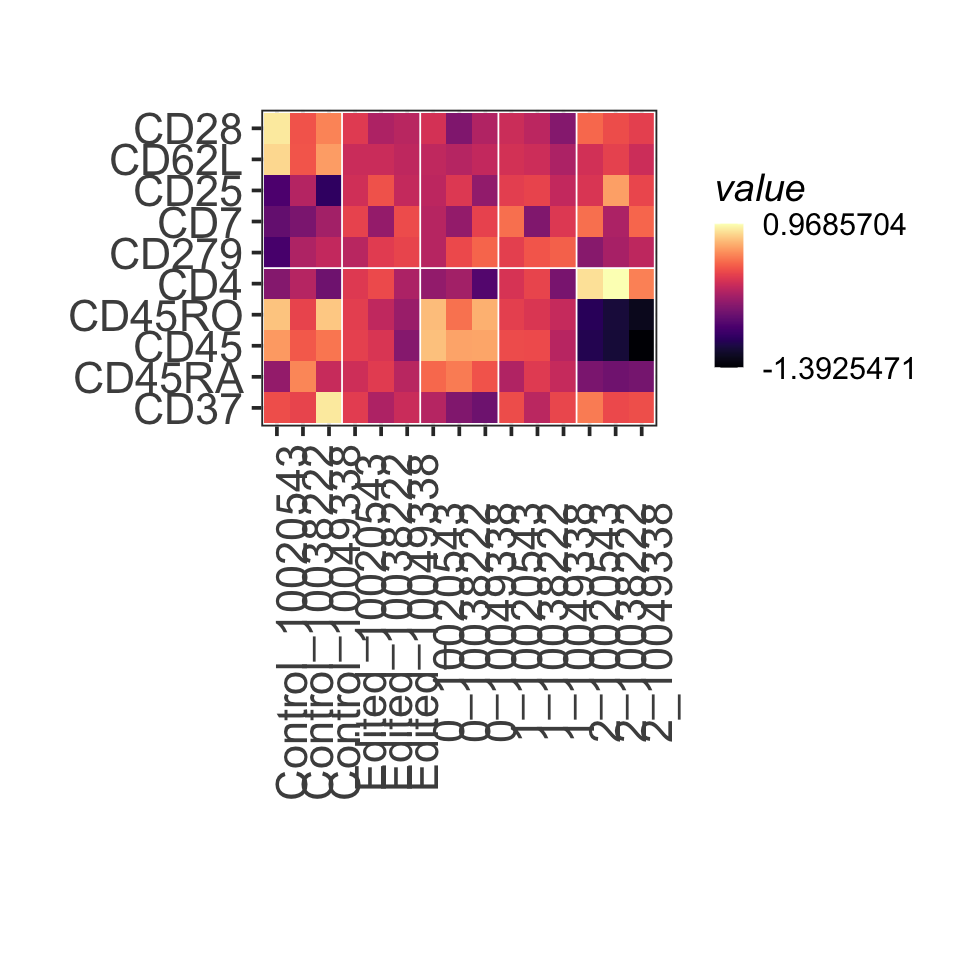

In [635]:
fig.size(8,8)
g <-  ggplot() + 
geom_tile(data = df_adt,
          aes(x = X, y = gene, fill = value)) + 
geom_tile(data = df2_adt,
          aes(x = X, y = gene, fill = value)) + 
scale_fill_viridis(option = "magma", breaks = c(max(df_adt$value, df2_adt$value), min(df_adt$value, df2_adt$value))) + 
theme_gy() + 
scale_y_discrete(limits = c(order_adt)) + 
theme(axis.text.x = element_text(angle = 90)) + 
scale_x_discrete(limits = c(unique(df2_adt$X),unique(df_adt$X))) + 
geom_vline(xintercept = c(3.5, 6.5, 9.5,12.5,15.5), color = "white")+
geom_hline(yintercept = 5.5, color = "white") + 
xlab("") + ylab("") +
  theme(legend.position = "right") + 
theme(aspect.ratio = 0.8)

plot(g)
## save the plot
suppressWarnings({ 
    ggsave(g, filename = "g.png", device = "png", dpi = 300)
    })

## Random Plots

In [ ]:
## Layer these together as was done in the past with FBXO11

In [134]:
CD45Plots3 <- CD45Plots3 %>% mutate(genotype3 = ifelse(Edited_Index == "Edited" & Dosage == 0, "C", 
                                        ifelse(Edited_Index == "Edited" & Dosage == 1, "C/T", 
                                              ifelse(Edited_Index == "Edited" & Dosage == 2, "T", "Control"))))

In [648]:
CD45_lm_Dosage %>% arrange(padjBH)

gene      (Intercept) log10(nUMI.y) PlateP3       PlateP4     
1    PTPRC      -9.118225  2.445656       0.28734860    0.193869496
2    ANXA3     -13.432073  2.556328       0.28211425    0.027903927
3    TNFRSF4    -4.197007  1.976669       0.05295609    0.143732884
4    CHCHD10   -10.604930  2.744217      -0.15127065    0.075360014
5    TRBC2      -6.128260  2.293284       0.20030552    0.109675976
6    MT-ND4     -4.341429  2.057043       0.29092294    0.266618460
7    PSMB6      -9.941476  2.696614      -0.12641378   -0.081808743
8    PSMA5     -10.324493  2.732694       0.14711876   -0.216517904
9    CDKAL1     -6.430931  1.487292      -0.36181936   -0.081107860
10   LBH        -9.136043  2.228083      -0.11646412    0.062391713
11   LINC01281  -7.928959  2.140220      -0.18064826   -0.237580671
12   SOCS3      -8.834327  1.994727       0.14673668   -0.059785769
13   PMAIP1    -15.019625  3.495275       0.37570573   -0.069114703
14   TIPIN     -11.585170  2.294703       0.72222041    0.543025606
15   DLG2       -8.166401  1.668406       0.07738144    0.173412931
16   RAMP1      -9.353740  1.817303      -0.19204917   -0.412817260
17   NEMP1     -10.485499  2.374831      -0.11551326    0.301174693
18   XBP1       -9.320271  2.516113       0.17401181   -0.203923104
19   PRDX1     -10.685343  2.953535       0.10970073   -0.006582289
20   CAVIN3     -8.692648  2.619465       0.27786290    0.255236592
21   NBEAL1     -6.731630  1.697972      -0.72367916   -0.527021013
22   MRPS6      -7.145873  2.036998      -0.11121475    0.081062101
23   TMEM70    -11.174762  2.558212       0.06168730    0.030995899
24   DCTN3      -7.615475  1.916358      -0.20003502   -0.168977837
25   C1QBP     -10.192605  2.754297       0.09029653   -0.068627958
26   LTB        -8.461711  2.598302      -0.16287207    0.140690034
27   CIB1       -8.142928  2.441900       0.08004253    0.010285943
28   PTTG1      -9.327517  2.496323      -0.18287350   -0.524862073
29   CUX1       -9.243851  2.078931      -0.51731863    0.329312604
30   LSM7       -7.946042  1.920951      -0.65890951   -0.472229990
⋮    ⋮         ⋮           ⋮             ⋮             ⋮           
5482 EIF5B      -9.471949   2.540633     -0.1110361673 -0.22241753 
5483 SRP72     -11.654428   3.011315      0.3303542673  0.28844984 
5484 KRT10      -5.665842   1.504869     -0.7646979537 -0.32002930 
5485 RUNX3      -7.138143   1.808617      0.0248274330  0.21654662 
5486 TRPT1      -7.905868   1.865850      0.2175039281  0.13860759 
5487 NOC2L     -12.310358   2.928205      0.2508536743  0.02730464 
5488 JAGN1      -9.667274   2.291000      0.3287241325  0.21371869 
5489 DPP3      -11.953831   2.836608     -0.0316946558  0.23738806 
5490 SLA2       -8.669561   2.038564      0.1313106640  0.03921848 
5491 SYPL1     -10.431574   2.391088      0.2295723754  0.11645748 
5492 RALBP1    -10.718220   2.591820     -0.2513556303 -0.24629950 
5493 ATG3      -10.948135   2.669039     -0.0507882429 -0.14950970 
5494 CD68       -7.756765   1.794607      0.0899754375  0.28999888 
5495 CARS2     -14.897215   3.588479     -0.1364019705  0.11025952 
5496 TPRA1      -9.585951   2.237458     -0.2772859898 -0.12610388 
5497 RBM7      -10.489817   2.266177      0.3561596585  0.09008674 
5498 GLOD4      -8.388630   1.823279     -0.2283067334  0.16818968 
5499 DDX19B    -11.888610   2.646990      0.0002743203 -0.15233339 
5500 ASB1       -6.825883   1.629044     -0.2354075341 -0.02217209 
5501 AKIRIN2    -8.656805   1.962078     -0.1934259410 -0.42402205 
5502 GADD45A    -8.991780   2.033535      0.1685652364 -0.03511118 
5503 STYXL1    -11.004217   2.497768      0.2299336417 -0.05321475 
5504 LINC01374  -7.739232   1.566835     -0.1308237055 -0.48628269 
5505 REEP4     -16.418362   3.766767     -0.0569828196 -0.18279156 
5506 RWDD4     -13.749330   2.983376      0.0241011060 -0.09659090 
5507 DHTKD1    -10.436234   2.333591     -0.0622748072 -0.15837639 
5508 PNPT1     -11.508749   2.352243      0.4938379619  0.542

In [698]:
norm_adt <- counts_ADT_filt_CD45 %>% singlecellmethods::normalizeData(method = "cellCLR")

Joining with `by = join_by(cell)`


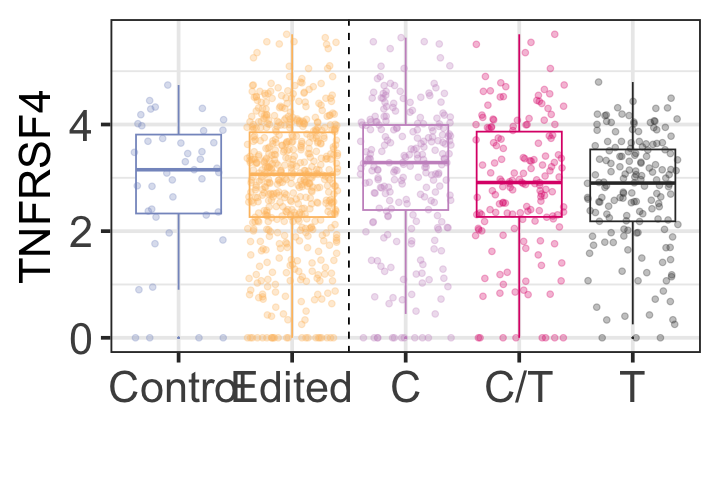

In [137]:
fig.size(4, 6)

norm_exprs["TNFRSF4",] %>% as_tibble(rownames = "cell") %>% inner_join(CD45Plots3) %>%  
    filter(genotype_count >2) %>% na.omit() %>%
{

ggplot(.) +  
geom_boxplot(data = ., outlier.size = 0,
             aes(Edited_Index, `value`, color = Edited_Index)) + 
geom_boxplot(outlier.size = 0, 
             data = . %>% filter(Edited_Index != "Control"),
             aes((genotype3), `value`, color = as.factor(genotype3))) +
geom_jitter(aes(Edited_Index, `value`, color = Edited_Index), 
           alpha = 0.3) + 
geom_jitter(data = . %>% filter(Edited_Index != "Control"),
             aes((genotype3), `value`, color = as.factor(genotype3)), 
           alpha = 0.3) + 
theme_gy()+
scale_x_discrete(limits = c("Control", 
                           "Edited", 
                           "C",
                           "C/T", 
                           "T"
                           )) + 
geom_vline(xintercept = 2.5, linetype = 2) + 
scale_color_manual(values = c(
          "Control" = "#8698C7",
          "Edited" = "#FDBF6E",
          "C" = "#C994C7",
          "C/T" = "#DD1C77", 
          "T" = "grey20"))+ 
xlab("") + 
ylab("TNFRSF4")+ 
theme(
     # axis.title.y = element_text(face = "italic"),
    legend.position = "none")
    
    }

Joining with `by = join_by(cell)`


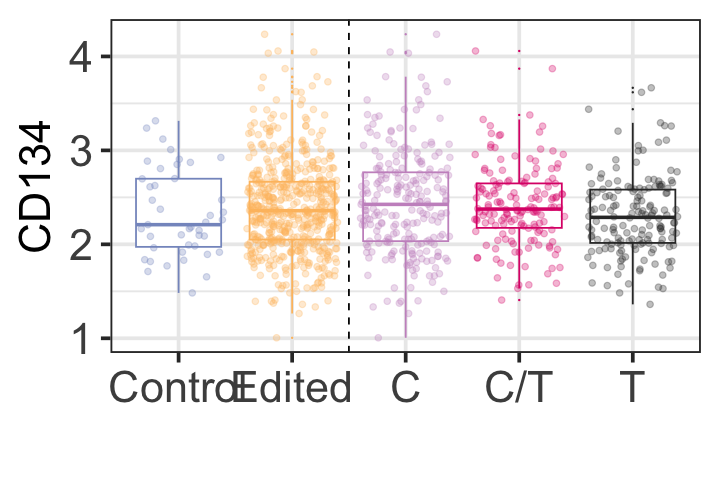

In [138]:
fig.size(4, 6)

norm_adt["CD134",] %>% as_tibble(rownames = "cell") %>% inner_join(CD45Plots3) %>%  
    filter(genotype_count >2) %>% na.omit() %>%
{

ggplot(.) +  
geom_boxplot(data = ., outlier.size = 0,
             aes(Edited_Index, `value`, color = Edited_Index)) + 
geom_boxplot(outlier.size = 0, 
             data = . %>% filter(Edited_Index != "Control"),
             aes((genotype3), `value`, color = as.factor(genotype3))) +
geom_jitter(aes(Edited_Index, `value`, color = Edited_Index), 
           alpha = 0.3) + 
geom_jitter(data = . %>% filter(Edited_Index != "Control"),
             aes((genotype3), `value`, color = as.factor(genotype3)), 
           alpha = 0.3) + 
theme_gy()+
scale_x_discrete(limits = c("Control", 
                           "Edited", 
                           "C",
                           "C/T", 
                           "T"
                           )) + 
geom_vline(xintercept = 2.5, linetype = 2) + 
scale_color_manual(values = c(
          "Control" = "#8698C7",
          "Edited" = "#FDBF6E",
          "C" = "#C994C7",
          "C/T" = "#DD1C77", 
          "T" = "grey20"))+ 
xlab("") + 
ylab("CD134")+ 
theme(
     # axis.title.y = element_text(face = "italic"),
    legend.position = "none")
    
    }

Joining with `by = join_by(cell)`


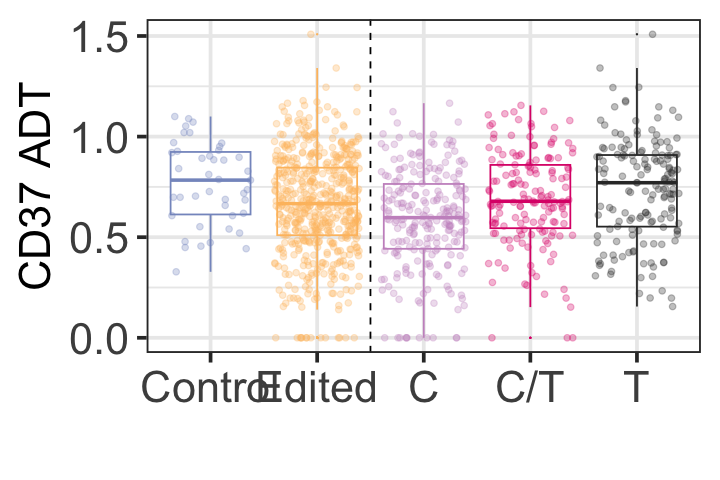

In [140]:
fig.size(4, 6)

norm_adt["CD37",] %>% as_tibble(rownames = "cell") %>% inner_join(CD45Plots3) %>%  
    filter(genotype_count >2) %>% na.omit() %>%
{

ggplot(.) +  
geom_boxplot(outlier.size = 0,
             aes(Edited_Index, `value`, color = Edited_Index)) + 
geom_boxplot(outlier.size = 0, 
             data = . %>% filter(genotype3 != "Control"),
             aes(genotype3, `value`, color = genotype3)) +
geom_jitter(aes(Edited_Index, `value`, color = Edited_Index), 
           alpha = 0.3) + 
geom_jitter(data = . %>% filter(genotype3 != "Control"),
             aes(genotype3, `value`, color = genotype3), 
           alpha = 0.3) + 
theme_gy()+
scale_x_discrete(limits = c("Control", 
                           "Edited", 
                           "C",
                           "C/T", 
                           "T"
                           )) + 
geom_vline(xintercept = 2.5, linetype = 2) + 
scale_color_manual(values = c(
          "Control" = "#8698C7",
          "Edited" = "#FDBF6E",
          "C" = "#C994C7",
          "C/T" = "#DD1C77", 
          "T" = "grey20"))+ 
xlab("") + 
ylab("CD37 ADT")+ 
theme(
     # axis.title.y = element_text(face = "italic"),
    legend.position = "none") 
    
} 

## Volacano Plots

In [84]:
CD45_lm_Dosage %>% head

gene   (Intercept) log10(nUMI.y) PlateP3    PlateP4    
1 MT-CO2 -3.5006194  2.130221      -0.1382712  0.01895425
2 MALAT1  0.2594335  1.074377      -0.1108392 -0.01603064
3 TPI1   -6.4686060  2.699072       0.2413221  0.21555403
4 TMSB10 -2.4553364  1.660458      -0.6509961 -0.33865911
5 RPLP0  -4.7499869  2.397953       0.1657264  0.08608635
6 RPL10  -4.0642373  2.128046      -0.2702097 -0.15602620
  Individual_Index10038222 Individual_Index10049338 Dosage      pval        
1 -0.16224820              -0.03200045               0.06022700 0.0190552005
2 -0.36429234              -0.05141699              -0.10926624 0.0063225546
3  0.05884542               0.01123968              -0.03282912 0.1155115471
4 -0.05277669               0.07546562               0.04831342 0.0208905896
5  0.08904630               0.04023906              -0.01874479 0.3397473431
6 -0.09286718              -0.04539214              -0.05280260 0.0008819483
  padjBH   
1 0.3968129
2 0.2791995
3 0.6810422
4 0.4044072
5 0.8293229
6 0.1430838

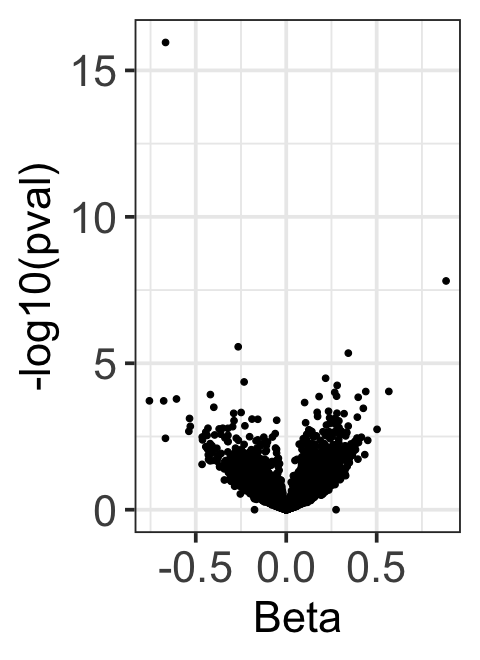

In [90]:
fig.size(5.5)
CD45_lm_Dosage %>% { 
    ggplot(., aes(Dosage, -log10(pval))) + geom_point() } + theme_gy() + xlab("Beta")

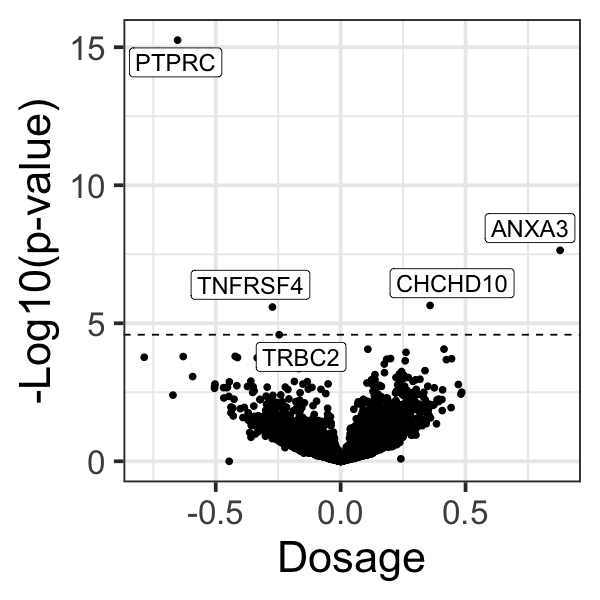

In [645]:
fig.size(5,5)
g <- CD45_lm_Dosage %>% {
ggplot(.) + 
geom_point(aes(Dosage, -log10(pval))) +
theme_gy() +
geom_label_repel(data = . %>% filter(padjBH < 0.05), 
               aes(Dosage, -log10(pval), label = gene), size = 5) + 
theme(legend.position = "none") + 
geom_hline(yintercept = -log10(CD45_lm_Dosage %>% arrange(pval) %>% filter(padjBH < 0.05) %>% tail(1) %>% with(pval)), linetype =2)+ 
ylab("-Log10(p-value)") +
    theme(axis.text.x = element_text(size = 20),
          axis.text.y = element_text(size = 20),
          strip.text = element_blank(), 
         panel.spacing = unit(1, "lines"))

}
g

In [112]:
ggsave(g, filename = "g.png", device = "png", width = 5, height = 5)

Warning message:
“ggrepel: 17 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


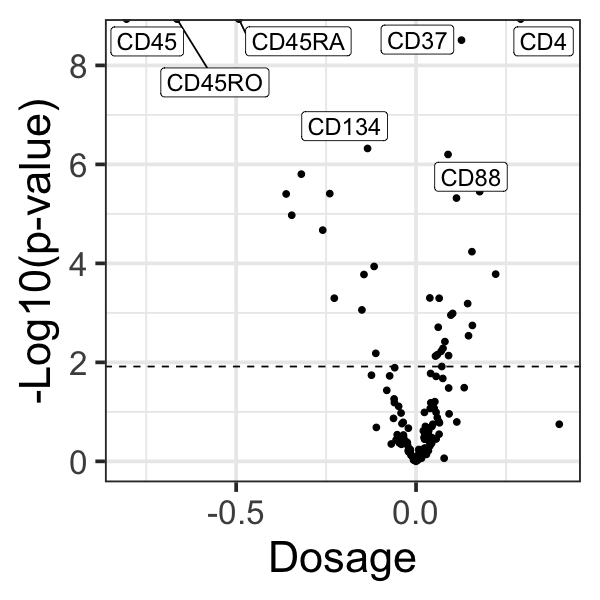

In [817]:
fig.size(5,5)
g <- CD45_lm_Dosage_adt %>% {
ggplot(.) + 
geom_point(aes(Dosage, -log10(pval))) +
theme_gy() +
geom_label_repel(data = . %>% filter(pval < 10^-6), 
               aes(Dosage, -log10(pval), label = gene), size = 5) + 
theme(legend.position = "none") + 
geom_hline(yintercept = -log10(CD45_lm_Dosage_adt %>% arrange(pval) %>% filter(padjBH < 0.05) %>% tail(1) %>% with(pval)), linetype =2)+ 
ylab("-Log10(p-value)") +
    theme(axis.text.x = element_text(size = 20),
          axis.text.y = element_text(size = 20),
          strip.text = element_blank(), 
         panel.spacing = unit(1, "lines"))

}
g